In [1]:
# Data directory /Users/scott/p5/data/interim/n35_train_valid_test

# python src/click_select2.py -i ~/hieroglyphs/Texts/AnteSouthWall.jpg -p data/water600/ -q 4


In [2]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg19 import decode_predictions
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from glob import glob
import os.path
import PIL
import cv2
import re
from collections import defaultdict, namedtuple
import pickle

from PIL import Image
from io import BytesIO
from IPython.display import HTML

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [4]:
pd.set_option('display.max_columns', None)

In [6]:
def get_classes(path):
    directories = glob(os.path.expanduser(path) + '/*')
    return [dir.split('/')[-1] for dir in directories]
n_classes =  len(get_classes('/home/scott/p5/data/water600_modeling/train/'))
n_classes

2

In [7]:
def to_gray_scale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    return np.array(gray_image)

In [8]:
def gray_and_scale(image):
    return cv2.resize(to_gray_scale(image), (224, 224))

In [9]:
def get_heat_value(img_segment, model, labels):
    resized_and_grayscaled_image = cv2.resize(to_gray_scale(img_segment), (224, 224))
    pred_array = model.predict(np.expand_dims(resized_and_grayscaled_image, axis=0))
    return pred_array
#     if labels[np.argmax(pred_array)] == 'N35':
#         return 1
#     elif labels[np.argmax(pred_array)] == 'N35_part':
#         return 0.5
#     else:
#         return 0
    
# get_heat_value(img_part, model, labels)

In [10]:
 vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [11]:
# note we exclude the final dense layers and add one back below, we would retrain it ourselves
base_model = vgg19
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False 
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(n_classes, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
train_path = os.path.expanduser('/home/scott/p5/data/water600_modeling/train/')
test_path = os.path.expanduser('/home/scott/p5/data/water600_modeling/test/')
valid_path = os.path.expanduser('/home/scott/p5/data/water600_modeling/valid/')

In [16]:
train_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(train_path,
                                                         target_size=(224,224), 
                                                         batch_size=6)
valid_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(valid_path, 
                                                         target_size=(224,224), 
                                                         batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(test_path, 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)


Found 282 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [17]:
# sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# patient early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model.fit_generator(train_batches, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches, 
                    validation_steps=4,
                    epochs=50,
                    verbose=2)#, 
#                     callbacks=[es, mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
 - 7s - loss: 2.8385 - acc: 0.7500 - val_loss: 3.6909 - val_acc: 0.7000
Epoch 2/50
 - 7s - loss: 4.4656 - acc: 0.5417 - val_loss: 1.2155 - val_acc: 0.8500
Epoch 3/50
 - 7s - loss: 4.3318 - acc: 0.5417 - val_loss: 1.2755 - val_acc: 0.8500
Epoch 4/50
 - 6s - loss: 0.9692 - acc: 0.8750 - val_loss: 2.2468 - val_acc: 0.5500
Epoch 5/50
 - 6s - loss: 3.6616 - acc: 0.6667 - val_loss: 3.1260 - val_acc: 0.6500
Epoch 6/50
 - 7s - loss: 4.9531 - acc: 0.3333 - val_loss: 1.7425 - val_acc: 0.8000
Epoch 7/50
 - 7s - loss: 1.4080 - acc: 0.7500 - val_loss: 2.0939 - val_acc: 0.7500
Epoch 8/50
 - 6s - loss: 2.2945 - acc: 0.6250 - val_loss: 2.4327 - val_acc: 0.5500
Epoch 9/50
 - 7s - loss: 2.1128 - acc: 0.5833 - val_loss: 1.9943 - val_acc: 0.7000
Epoch 10/50
 - 7s - loss: 1.2654 - acc: 0.7917 - val_loss: 1.0692 - val_acc: 0.7000
Epoch 11/50
 - 6s - loss: 2.1820 - acc: 0.6250 - val_loss: 1.2200 - val_a

In [ ]:
for key in hist.history:
    print(key)

In [ ]:
asdf =

In [ ]:
!ls

In [19]:
model.save('hieroglyphs_vgg19_N35_only_custom_images_small_test.h5')

In [ ]:
# model = load_model(os.path.expanduser('hieroglyphs_vgg19_N35_only_custom_images_two_class.h5'))

In [ ]:
# predictions = model.predict_generator(test_batches, steps=1, verbose=1)

In [20]:
STEP_SIZE_TEST=test_batches.n//test_batches.batch_size
test_batches.reset()
pred=model.predict_generator(test_batches,
steps=STEP_SIZE_TEST,
verbose=1)
# print(pred)

56/56 [==============================] - 10s 172ms/step


In [21]:
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
labels = (train_batches.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
print(labels)
predictions = [labels[k] for k in predicted_class_indices]

{'glyphs': 0, 'non_glyphs': 1}
{0: 'glyphs', 1: 'non_glyphs'}


In [23]:
predictions[:11]

['glyphs',
 'glyphs',
 'glyphs',
 'glyphs',
 'glyphs',
 'glyphs',
 'glyphs',
 'non_glyphs',
 'glyphs',
 'glyphs',
 'non_glyphs']

In [24]:
def get_glyph_name(series):
    file = series['filename']
    m = re.match(r'^([A-Z]{1}\d+)/', file)
    part = re.search(r'(N35_part)/', file)
    if m:
        return m.group(1)
    elif part:
        return part.group(1)
    else:
        return 'noise'

In [25]:
pred_df = pd.DataFrame(predictions, columns=['predicted'])
pred_df = pred_df.merge(pd.DataFrame(test_batches.filenames, columns=['filename']), left_index=True, right_index=True)
pred_df['glyph'] = pred_df.apply(lambda row: get_glyph_name(row), axis=1)
pred_df['match'] = pred_df['predicted'] == pred_df['glyph']
pred_df.to_csv('/Users/scott/p5/N35_predictions_custom_images.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/scott/p5/N35_predictions_custom_images.csv'

In [ ]:
acc = pred_df['match'].sum() / len(pred_df)
acc

In [ ]:
pred_df.sample(5)

(1218, 1720, 3)
(609, 860, 3)


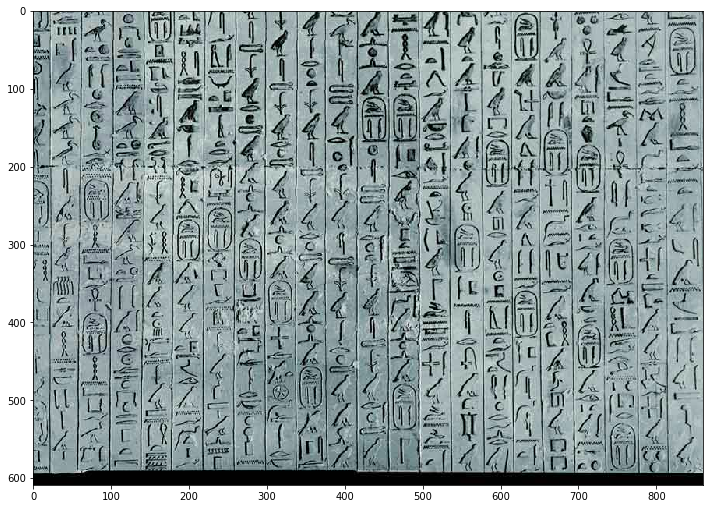

In [27]:
# Orig Image Shape (1507, 1720, 3)
# img = cv2.imread('/home/scott/sync/Antewest.jpg')[250:1000, 1220:]
img = cv2.imread(os.path.expanduser('~/hieroglyphs/Texts/AnteSouthWall.jpg'))

# *************************************************************
height, width, depth = img.shape
print((height, width, depth))
half_width = width // 2
half_height = height // 2
img = img[half_height:, half_width:].copy()
            
print(img.shape)
plt.figure(figsize=(12,12))
plt.imshow(img)


In [28]:
heat_map = []
window_height = 40
window_width = 40
for y_step in range(0, img.shape[0], 5):
    for x_step in range(0, img.shape[1], 5):
        print((x_step, y_step))
        # Get window_width x window_height image segement
        crop_img = img[y_step:y_step+window_height, x_step:x_step+window_width].copy()
        # Get the heat value of the image segemnt
        heat = get_heat_value(crop_img, model, labels)
        # Appened heat value to heat map
        print(heat)
        heat_map.append(heat)

(0, 0)
[[6.027167e-09 1.000000e+00]]
(5, 0)
[[1.1605383e-07 9.9999988e-01]]
(10, 0)
[[0.44399753 0.5560025 ]]
(15, 0)
[[0.20037876 0.7996213 ]]
(20, 0)
[[2.7510463e-04 9.9972492e-01]]
(25, 0)
[[1.6188672e-04 9.9983811e-01]]
(30, 0)
[[0.956933  0.0430669]]
(35, 0)
[[1.0000000e+00 3.5101914e-11]]
(40, 0)
[[0.43108776 0.56891215]]
(45, 0)
[[0.7092837 0.2907162]]
(50, 0)
[[1.0000000e+00 3.3139737e-13]]
(55, 0)
[[9.9969089e-01 3.0908475e-04]]
(60, 0)
[[1.5083667e-04 9.9984908e-01]]
(65, 0)
[[2.2067406e-06 9.9999774e-01]]
(70, 0)
[[9.5592338e-07 9.9999905e-01]]
(75, 0)
[[9.9960262e-01 3.9738786e-04]]
(80, 0)
[[9.9999464e-01 5.3294980e-06]]
(85, 0)
[[0.9706616  0.02933838]]
(90, 0)
[[9.4016246e-04 9.9905986e-01]]
(95, 0)
[[1.6543657e-08 1.0000000e+00]]
(100, 0)
[[4.4546353e-09 1.0000000e+00]]
(105, 0)
[[9.5735058e-06 9.9999046e-01]]
(110, 0)
[[0.00109233 0.9989077 ]]
(115, 0)
[[0.99376136 0.00623862]]
(120, 0)
[[0.8825622  0.11743779]]
(125, 0)
[[2.1449485e-14 1.0000000e+00]]
(130, 0)
[[1.790

[[5.6008436e-12 1.0000000e+00]]
(210, 5)
[[1.1721681e-08 1.0000000e+00]]
(215, 5)
[[1.5596031e-06 9.9999845e-01]]
(220, 5)
[[0.58661985 0.41338015]]
(225, 5)
[[3.9822089e-06 9.9999607e-01]]
(230, 5)
[[1.6665421e-04 9.9983335e-01]]
(235, 5)
[[0.0113698 0.9886302]]
(240, 5)
[[1.2273898e-06 9.9999881e-01]]
(245, 5)
[[7.8417687e-13 1.0000000e+00]]
(250, 5)
[[4.6573027e-16 1.0000000e+00]]
(255, 5)
[[3.0778298e-09 1.0000000e+00]]
(260, 5)
[[0.59262514 0.40737483]]
(265, 5)
[[0.03830092 0.9616991 ]]
(270, 5)
[[7.8386057e-04 9.9921608e-01]]
(275, 5)
[[0.0019098 0.9980902]]
(280, 5)
[[2.758194e-11 1.000000e+00]]
(285, 5)
[[1.1475071e-04 9.9988520e-01]]
(290, 5)
[[9.9999976e-01 2.7262831e-07]]
(295, 5)
[[9.9921227e-01 7.8766997e-04]]
(300, 5)
[[0.9248331  0.07516694]]
(305, 5)
[[0.59608227 0.40391776]]
(310, 5)
[[1.05618026e-04 9.99894381e-01]]
(315, 5)
[[8.818542e-12 1.000000e+00]]
(320, 5)
[[2.0382858e-10 1.0000000e+00]]
(325, 5)
[[4.861828e-09 1.000000e+00]]
(330, 5)
[[0.41159627 0.58840376]]

[[3.0622405e-06 9.9999690e-01]]
(405, 10)
[[0.00107391 0.9989261 ]]
(410, 10)
[[4.922706e-06 9.999951e-01]]
(415, 10)
[[0.00185854 0.9981414 ]]
(420, 10)
[[0.9970686  0.00293149]]
(425, 10)
[[0.5176089  0.48239115]]
(430, 10)
[[8.719893e-06 9.999913e-01]]
(435, 10)
[[1.3750599e-14 1.0000000e+00]]
(440, 10)
[[9.7309815e-14 1.0000000e+00]]
(445, 10)
[[1.5967618e-11 1.0000000e+00]]
(450, 10)
[[0.96163595 0.03836406]]
(455, 10)
[[1.000000e+00 5.309014e-09]]
(460, 10)
[[0.9589728  0.04102723]]
(465, 10)
[[5.462534e-07 9.999994e-01]]
(470, 10)
[[9.4882286e-14 1.0000000e+00]]
(475, 10)
[[5.5109197e-08 1.0000000e+00]]
(480, 10)
[[0.17335856 0.8266415 ]]
(485, 10)
[[1.8539486e-14 1.0000000e+00]]
(490, 10)
[[2.7684651e-12 1.0000000e+00]]
(495, 10)
[[8.418513e-13 1.000000e+00]]
(500, 10)
[[7.977066e-11 1.000000e+00]]
(505, 10)
[[0.00125783 0.99874216]]
(510, 10)
[[2.6611690e-07 9.9999976e-01]]
(515, 10)
[[2.0954433e-07 9.9999976e-01]]
(520, 10)
[[1.26308694e-11 1.00000000e+00]]
(525, 10)
[[1.0169

[[0.11827196 0.88172805]]
(580, 15)
[[0.09578356 0.9042164 ]]
(585, 15)
[[2.6429312e-13 1.0000000e+00]]
(590, 15)
[[9.053883e-15 1.000000e+00]]
(595, 15)
[[4.9011476e-16 1.0000000e+00]]
(600, 15)
[[5.102338e-13 1.000000e+00]]
(605, 15)
[[5.5587527e-08 1.0000000e+00]]
(610, 15)
[[1.118958e-05 9.999888e-01]]
(615, 15)
[[1.0943547e-10 1.0000000e+00]]
(620, 15)
[[1.0697525e-10 1.0000000e+00]]
(625, 15)
[[2.8241075e-12 1.0000000e+00]]
(630, 15)
[[4.258425e-13 1.000000e+00]]
(635, 15)
[[0.00386322 0.9961367 ]]
(640, 15)
[[6.286178e-13 1.000000e+00]]
(645, 15)
[[1.0770041e-04 9.9989223e-01]]
(650, 15)
[[0.8783324  0.12166759]]
(655, 15)
[[0.9751932  0.02480685]]
(660, 15)
[[9.9978739e-01 2.1262685e-04]]
(665, 15)
[[9.9996114e-01 3.8900787e-05]]
(670, 15)
[[9.58535e-13 1.00000e+00]]
(675, 15)
[[1.8621186e-09 1.0000000e+00]]
(680, 15)
[[0.08384248 0.9161576 ]]
(685, 15)
[[1.0000000e+00 1.2539749e-11]]
(690, 15)
[[1.0000000e+00 6.2039827e-15]]
(695, 15)
[[1.000000e+00 6.102761e-10]]
(700, 15)
[[

[[0.8117039  0.18829614]]
(755, 20)
[[1.2600792e-07 9.9999988e-01]]
(760, 20)
[[0.01641424 0.9835857 ]]
(765, 20)
[[1.0000000e+00 3.1791565e-08]]
(770, 20)
[[9.9999726e-01 2.7575543e-06]]
(775, 20)
[[9.9999857e-01 1.4797168e-06]]
(780, 20)
[[0.00424591 0.9957541 ]]
(785, 20)
[[3.3534918e-06 9.9999666e-01]]
(790, 20)
[[9.593821e-24 1.000000e+00]]
(795, 20)
[[1.1859082e-16 1.0000000e+00]]
(800, 20)
[[7.0115545e-15 1.0000000e+00]]
(805, 20)
[[7.2772696e-06 9.9999273e-01]]
(810, 20)
[[9.9991846e-01 8.1552294e-05]]
(815, 20)
[[0.9981337  0.00186628]]
(820, 20)
[[0.90840447 0.09159557]]
(825, 20)
[[2.5216074e-04 9.9974781e-01]]
(830, 20)
[[2.0791854e-04 9.9979204e-01]]
(835, 20)
[[0.9440775  0.05592247]]
(840, 20)
[[0.99873286 0.00126715]]
(845, 20)
[[9.9999738e-01 2.6172243e-06]]
(850, 20)
[[0.9719828  0.02801722]]
(855, 20)
[[0.99701643 0.00298353]]
(0, 25)
[[7.734192e-14 1.000000e+00]]
(5, 25)
[[1.3969839e-04 9.9986029e-01]]
(10, 25)
[[1.7092237e-06 9.9999833e-01]]
(15, 25)
[[4.6319978e-1

[[9.9910396e-01 8.9595525e-04]]
(70, 30)
[[0.18762168 0.81237835]]
(75, 30)
[[1.2977329e-10 1.0000000e+00]]
(80, 30)
[[5.972846e-05 9.999403e-01]]
(85, 30)
[[7.108646e-14 1.000000e+00]]
(90, 30)
[[3.2621407e-13 1.0000000e+00]]
(95, 30)
[[5.765654e-08 1.000000e+00]]
(100, 30)
[[1.598218e-11 1.000000e+00]]
(105, 30)
[[1.988335e-08 1.000000e+00]]
(110, 30)
[[0.998381 0.001619]]
(115, 30)
[[0.5124062  0.48759377]]
(120, 30)
[[3.5218523e-08 1.0000000e+00]]
(125, 30)
[[1.2997151e-17 1.0000000e+00]]
(130, 30)
[[2.0805972e-22 1.0000000e+00]]
(135, 30)
[[5.414286e-23 1.000000e+00]]
(140, 30)
[[2.7683747e-16 1.0000000e+00]]
(145, 30)
[[9.079681e-16 1.000000e+00]]
(150, 30)
[[0.00126593 0.99873406]]
(155, 30)
[[1.4535579e-18 1.0000000e+00]]
(160, 30)
[[1.0433874e-08 1.0000000e+00]]
(165, 30)
[[1.951986e-09 1.000000e+00]]
(170, 30)
[[1.4257245e-13 1.0000000e+00]]
(175, 30)
[[0.51419735 0.48580265]]
(180, 30)
[[0.9903741  0.00962591]]
(185, 30)
[[1.2273007e-05 9.9998772e-01]]
(190, 30)
[[1.2485192e

[[3.3374577e-12 1.0000000e+00]]
(245, 35)
[[4.298829e-09 1.000000e+00]]
(250, 35)
[[4.2973025e-07 9.9999952e-01]]
(255, 35)
[[3.899063e-05 9.999610e-01]]
(260, 35)
[[1.4295541e-04 9.9985707e-01]]
(265, 35)
[[0.00342549 0.9965745 ]]
(270, 35)
[[2.2095055e-05 9.9997795e-01]]
(275, 35)
[[2.4827874e-15 1.0000000e+00]]
(280, 35)
[[1.7382636e-08 1.0000000e+00]]
(285, 35)
[[2.3155283e-15 1.0000000e+00]]
(290, 35)
[[1.6687344e-12 1.0000000e+00]]
(295, 35)
[[4.0859973e-08 1.0000000e+00]]
(300, 35)
[[0.00155626 0.9984438 ]]
(305, 35)
[[9.9976903e-01 2.3095573e-04]]
(310, 35)
[[9.9996126e-01 3.8748320e-05]]
(315, 35)
[[1.00000e+00 3.10428e-08]]
(320, 35)
[[0.00960575 0.9903943 ]]
(325, 35)
[[1.7821923e-08 1.0000000e+00]]
(330, 35)
[[7.7094395e-05 9.9992287e-01]]
(335, 35)
[[0.43086076 0.5691393 ]]
(340, 35)
[[1.0000000e+00 1.7340686e-11]]
(345, 35)
[[1.0000000e+00 5.9570854e-13]]
(350, 35)
[[9.9920827e-01 7.9172343e-04]]
(355, 35)
[[1.9603542e-06 9.9999809e-01]]
(360, 35)
[[1.1654129e-09 1.000000

[[1.4788471e-21 1.0000000e+00]]
(420, 40)
[[3.189345e-10 1.000000e+00]]
(425, 40)
[[0.4191343  0.58086574]]
(430, 40)
[[1.0896443e-06 9.9999893e-01]]
(435, 40)
[[2.0092964e-05 9.9997985e-01]]
(440, 40)
[[0.00158143 0.99841857]]
(445, 40)
[[1.1754623e-06 9.9999881e-01]]
(450, 40)
[[0.99856144 0.00143854]]
(455, 40)
[[1.000000e+00 7.950128e-09]]
(460, 40)
[[1.000000e+00 4.704602e-09]]
(465, 40)
[[0.26922277 0.73077714]]
(470, 40)
[[1.0375012e-12 1.0000000e+00]]
(475, 40)
[[1.0821842e-19 1.0000000e+00]]
(480, 40)
[[4.1410696e-18 1.0000000e+00]]
(485, 40)
[[0.00129542 0.99870455]]
(490, 40)
[[0.80080384 0.19919616]]
(495, 40)
[[1.0000000e+00 4.8237786e-10]]
(500, 40)
[[1.0000000e+00 2.2536317e-09]]
(505, 40)
[[0.00764081 0.9923592 ]]
(510, 40)
[[4.2290292e-08 1.0000000e+00]]
(515, 40)
[[9.0828715e-15 1.0000000e+00]]
(520, 40)
[[2.995258e-08 1.000000e+00]]
(525, 40)
[[3.2635875e-05 9.9996734e-01]]
(530, 40)
[[2.5303319e-07 9.9999976e-01]]
(535, 40)
[[0.90322024 0.09677981]]
(540, 40)
[[2.49

[[3.0990494e-12 1.0000000e+00]]
(595, 45)
[[6.5782904e-09 1.0000000e+00]]
(600, 45)
[[6.632709e-23 1.000000e+00]]
(605, 45)
[[1.087251e-15 1.000000e+00]]
(610, 45)
[[1.1283233e-04 9.9988711e-01]]
(615, 45)
[[4.54938e-09 1.00000e+00]]
(620, 45)
[[5.106630e-07 9.999995e-01]]
(625, 45)
[[3.6370542e-11 1.0000000e+00]]
(630, 45)
[[3.9305895e-08 1.0000000e+00]]
(635, 45)
[[1.0791328e-09 1.0000000e+00]]
(640, 45)
[[3.9226546e-07 9.9999964e-01]]
(645, 45)
[[6.6480745e-11 1.0000000e+00]]
(650, 45)
[[0.00284563 0.99715436]]
(655, 45)
[[7.1743608e-04 9.9928254e-01]]
(660, 45)
[[9.9997115e-01 2.8824443e-05]]
(665, 45)
[[0.97505784 0.02494209]]
(670, 45)
[[0.00271892 0.9972811 ]]
(675, 45)
[[0.18187357 0.8181265 ]]
(680, 45)
[[9.9980587e-01 1.9413982e-04]]
(685, 45)
[[9.999982e-01 1.741443e-06]]
(690, 45)
[[0.6182361  0.38176388]]
(695, 45)
[[0.3718458 0.6281542]]
(700, 45)
[[1.6889833e-04 9.9983108e-01]]
(705, 45)
[[7.977372e-04 9.992023e-01]]
(710, 45)
[[7.927297e-08 9.999999e-01]]
(715, 45)
[[2.

[[0.99757046 0.00242948]]
(770, 50)
[[0.91963404 0.08036596]]
(775, 50)
[[0.97587335 0.02412672]]
(780, 50)
[[1.000000e+00 3.059462e-10]]
(785, 50)
[[0.98788005 0.01211999]]
(790, 50)
[[4.0502518e-11 1.0000000e+00]]
(795, 50)
[[4.3892678e-11 1.0000000e+00]]
(800, 50)
[[2.6981083e-05 9.9997306e-01]]
(805, 50)
[[4.765164e-09 1.000000e+00]]
(810, 50)
[[1.0000000e+00 1.1267144e-09]]
(815, 50)
[[1.0000000e+00 1.8303472e-11]]
(820, 50)
[[9.9999940e-01 5.8752335e-07]]
(825, 50)
[[0.96196157 0.0380384 ]]
(830, 50)
[[0.0028411 0.9971589]]
(835, 50)
[[1.828212e-04 9.998172e-01]]
(840, 50)
[[9.8887016e-05 9.9990106e-01]]
(845, 50)
[[3.2026777e-09 1.0000000e+00]]
(850, 50)
[[0.8380226  0.16197741]]
(855, 50)
[[9.9914074e-01 8.5927173e-04]]
(0, 55)
[[0.61924905 0.38075092]]
(5, 55)
[[4.2485517e-13 1.0000000e+00]]
(10, 55)
[[4.578396e-07 9.999995e-01]]
(15, 55)
[[9.9988496e-01 1.1500990e-04]]
(20, 55)
[[3.9688774e-04 9.9960309e-01]]
(25, 55)
[[1.9789734e-09 1.0000000e+00]]
(30, 55)
[[4.7918047e-09 1

[[3.45924e-11 1.00000e+00]]
(85, 60)
[[2.7953459e-07 9.9999976e-01]]
(90, 60)
[[9.994820e-01 5.181082e-04]]
(95, 60)
[[2.1413571e-06 9.9999785e-01]]
(100, 60)
[[0.0110499 0.9889501]]
(105, 60)
[[1.0000000e+00 4.8581217e-08]]
(110, 60)
[[9.9999976e-01 2.8602005e-07]]
(115, 60)
[[3.8862713e-06 9.9999607e-01]]
(120, 60)
[[0.00141148 0.9985885 ]]
(125, 60)
[[3.3157466e-11 1.0000000e+00]]
(130, 60)
[[1.5064031e-16 1.0000000e+00]]
(135, 60)
[[9.0236631e-07 9.9999905e-01]]
(140, 60)
[[9.9999928e-01 7.5561604e-07]]
(145, 60)
[[1.0000000e+00 2.1180444e-09]]
(150, 60)
[[5.6223016e-05 9.9994373e-01]]
(155, 60)
[[9.9975497e-01 2.4507631e-04]]
(160, 60)
[[1.6391252e-05 9.9998355e-01]]
(165, 60)
[[0.17525557 0.8247444 ]]
(170, 60)
[[9.9999964e-01 3.7679183e-07]]
(175, 60)
[[9.1094962e-06 9.9999094e-01]]
(180, 60)
[[8.556719e-06 9.999914e-01]]
(185, 60)
[[1.441706e-12 1.000000e+00]]
(190, 60)
[[8.620392e-12 1.000000e+00]]
(195, 60)
[[1.3848954e-11 1.0000000e+00]]
(200, 60)
[[1.7682922e-09 1.0000000e+

[[0.9986578  0.00134212]]
(260, 65)
[[0.99717677 0.0028232 ]]
(265, 65)
[[0.00621051 0.9937895 ]]
(270, 65)
[[2.0795945e-07 9.9999976e-01]]
(275, 65)
[[2.4310296e-08 1.0000000e+00]]
(280, 65)
[[3.3816137e-05 9.9996614e-01]]
(285, 65)
[[4.0972850e-06 9.9999595e-01]]
(290, 65)
[[0.01898276 0.9810173 ]]
(295, 65)
[[9.9966943e-01 3.3052810e-04]]
(300, 65)
[[0.09208331 0.90791667]]
(305, 65)
[[0.02154415 0.97845584]]
(310, 65)
[[0.22340451 0.77659553]]
(315, 65)
[[4.0495155e-16 1.0000000e+00]]
(320, 65)
[[1.661065e-13 1.000000e+00]]
(325, 65)
[[2.3502973e-15 1.0000000e+00]]
(330, 65)
[[4.2625717e-07 9.9999952e-01]]
(335, 65)
[[0.99777454 0.00222543]]
(340, 65)
[[6.0950763e-12 1.0000000e+00]]
(345, 65)
[[5.0318384e-19 1.0000000e+00]]
(350, 65)
[[2.3475994e-23 1.0000000e+00]]
(355, 65)
[[3.187574e-22 1.000000e+00]]
(360, 65)
[[0.32571396 0.67428607]]
(365, 65)
[[0.9903882  0.00961183]]
(370, 65)
[[0.84670496 0.15329508]]
(375, 65)
[[0.99702567 0.00297437]]
(380, 65)
[[1.0000000e+00 3.3840006e

[[0.8239384  0.17606163]]
(430, 70)
[[1.1770094e-12 1.0000000e+00]]
(435, 70)
[[4.5593806e-05 9.9995446e-01]]
(440, 70)
[[2.5198437e-04 9.9974805e-01]]
(445, 70)
[[9.348937e-10 1.000000e+00]]
(450, 70)
[[2.1261484e-12 1.0000000e+00]]
(455, 70)
[[3.5897543e-07 9.9999964e-01]]
(460, 70)
[[1.2086053e-05 9.9998796e-01]]
(465, 70)
[[7.939493e-08 9.999999e-01]]
(470, 70)
[[2.0246546e-14 1.0000000e+00]]
(475, 70)
[[2.9021564e-12 1.0000000e+00]]
(480, 70)
[[4.783128e-10 1.000000e+00]]
(485, 70)
[[6.1761325e-11 1.0000000e+00]]
(490, 70)
[[8.132882e-04 9.991867e-01]]
(495, 70)
[[2.9761640e-07 9.9999976e-01]]
(500, 70)
[[7.5581495e-04 9.9924421e-01]]
(505, 70)
[[0.11086813 0.8891319 ]]
(510, 70)
[[0.09742808 0.9025719 ]]
(515, 70)
[[0.06324396 0.936756  ]]
(520, 70)
[[0.00554125 0.9944588 ]]
(525, 70)
[[4.4696346e-08 1.0000000e+00]]
(530, 70)
[[0.00117266 0.9988273 ]]
(535, 70)
[[0.00235962 0.9976404 ]]
(540, 70)
[[0.9668702  0.03312982]]
(545, 70)
[[1.0000000e+00 1.7478516e-08]]
(550, 70)
[[3.88

[[1.9000165e-04 9.9981004e-01]]
(600, 75)
[[9.996284e-01 3.716068e-04]]
(605, 75)
[[1.03164366e-10 1.00000000e+00]]
(610, 75)
[[1.5588517e-10 1.0000000e+00]]
(615, 75)
[[3.421631e-16 1.000000e+00]]
(620, 75)
[[9.968844e-16 1.000000e+00]]
(625, 75)
[[1.7357227e-19 1.0000000e+00]]
(630, 75)
[[9.6789954e-06 9.9999034e-01]]
(635, 75)
[[0.9760275  0.02397251]]
(640, 75)
[[0.00148812 0.99851185]]
(645, 75)
[[8.504185e-05 9.999150e-01]]
(650, 75)
[[0.94819915 0.05180081]]
(655, 75)
[[0.00943203 0.990568  ]]
(660, 75)
[[3.4683501e-07 9.9999964e-01]]
(665, 75)
[[7.828248e-16 1.000000e+00]]
(670, 75)
[[6.666076e-12 1.000000e+00]]
(675, 75)
[[8.6100143e-04 9.9913895e-01]]
(680, 75)
[[2.9618757e-06 9.9999702e-01]]
(685, 75)
[[8.7798719e-07 9.9999917e-01]]
(690, 75)
[[0.0323193 0.9676807]]
(695, 75)
[[1.5432472e-05 9.9998462e-01]]
(700, 75)
[[2.8502237e-07 9.9999976e-01]]
(705, 75)
[[2.8638306e-07 9.9999976e-01]]
(710, 75)
[[1.7313564e-10 1.0000000e+00]]
(715, 75)
[[0.07432498 0.9256751 ]]
(720, 75

[[2.004266e-08 1.000000e+00]]
(770, 80)
[[1.4536624e-08 1.0000000e+00]]
(775, 80)
[[0.00689435 0.9931057 ]]
(780, 80)
[[0.39544567 0.6045543 ]]
(785, 80)
[[7.546545e-04 9.992454e-01]]
(790, 80)
[[1.7010606e-11 1.0000000e+00]]
(795, 80)
[[2.4693825e-09 1.0000000e+00]]
(800, 80)
[[0.00442452 0.99557555]]
(805, 80)
[[5.0980407e-08 1.0000000e+00]]
(810, 80)
[[3.3964454e-05 9.9996603e-01]]
(815, 80)
[[0.42027193 0.579728  ]]
(820, 80)
[[9.9977726e-01 2.2273191e-04]]
(825, 80)
[[1.0000000e+00 6.0041394e-09]]
(830, 80)
[[0.00530526 0.99469477]]
(835, 80)
[[9.977329e-05 9.999002e-01]]
(840, 80)
[[2.7894339e-07 9.9999976e-01]]
(845, 80)
[[0.9985806  0.00141946]]
(850, 80)
[[0.99899346 0.00100656]]
(855, 80)
[[9.9999988e-01 1.0585379e-07]]
(0, 85)
[[3.103256e-05 9.999690e-01]]
(5, 85)
[[9.254202e-04 9.990746e-01]]
(10, 85)
[[0.78176564 0.21823438]]
(15, 85)
[[9.9999893e-01 1.0388211e-06]]
(20, 85)
[[0.00255755 0.9974425 ]]
(25, 85)
[[5.6931103e-06 9.9999428e-01]]
(30, 85)
[[0.8483564  0.15164365

[[4.3231065e-11 1.0000000e+00]]
(90, 90)
[[7.0625276e-08 9.9999988e-01]]
(95, 90)
[[9.999589e-01 4.116558e-05]]
(100, 90)
[[9.9999905e-01 9.5085812e-07]]
(105, 90)
[[9.9999964e-01 3.7153299e-07]]
(110, 90)
[[0.2793906  0.72060937]]
(115, 90)
[[4.6217917e-08 1.0000000e+00]]
(120, 90)
[[0.01252584 0.9874742 ]]
(125, 90)
[[2.5285547e-09 1.0000000e+00]]
(130, 90)
[[5.1596348e-14 1.0000000e+00]]
(135, 90)
[[6.9164436e-17 1.0000000e+00]]
(140, 90)
[[9.6055636e-11 1.0000000e+00]]
(145, 90)
[[6.923179e-08 9.999999e-01]]
(150, 90)
[[0.9627573  0.03724269]]
(155, 90)
[[9.321337e-05 9.999068e-01]]
(160, 90)
[[1.2555444e-12 1.0000000e+00]]
(165, 90)
[[6.6265555e-18 1.0000000e+00]]
(170, 90)
[[1.8677972e-15 1.0000000e+00]]
(175, 90)
[[0.00529035 0.9947096 ]]
(180, 90)
[[0.0138004 0.9861996]]
(185, 90)
[[0.00102296 0.99897707]]
(190, 90)
[[1.2168516e-10 1.0000000e+00]]
(195, 90)
[[0.00207515 0.9979248 ]]
(200, 90)
[[1.3070675e-07 9.9999988e-01]]
(205, 90)
[[4.6612615e-05 9.9995339e-01]]
(210, 90)
[[

[[1.0000000e+00 1.2436683e-11]]
(270, 95)
[[0.97462904 0.02537096]]
(275, 95)
[[1.9314011e-14 1.0000000e+00]]
(280, 95)
[[1.4573414e-11 1.0000000e+00]]
(285, 95)
[[4.522217e-12 1.000000e+00]]
(290, 95)
[[0.22140566 0.7785944 ]]
(295, 95)
[[0.98017704 0.01982291]]
(300, 95)
[[1.0000000e+00 2.3250846e-10]]
(305, 95)
[[1.0000000e+00 6.6330425e-14]]
(310, 95)
[[9.9937576e-01 6.2430784e-04]]
(315, 95)
[[3.9671204e-04 9.9960333e-01]]
(320, 95)
[[5.8885113e-10 1.0000000e+00]]
(325, 95)
[[1.3535685e-10 1.0000000e+00]]
(330, 95)
[[2.4478834e-07 9.9999976e-01]]
(335, 95)
[[8.5603996e-10 1.0000000e+00]]
(340, 95)
[[0.99758565 0.00241432]]
(345, 95)
[[1.0000000e+00 2.5004996e-11]]
(350, 95)
[[0.3045605 0.6954394]]
(355, 95)
[[4.7850956e-11 1.0000000e+00]]
(360, 95)
[[1.13072836e-07 9.99999881e-01]]
(365, 95)
[[9.9999797e-01 2.0356285e-06]]
(370, 95)
[[0.9048813  0.09511864]]
(375, 95)
[[0.01348313 0.98651683]]
(380, 95)
[[0.51854414 0.4814558 ]]
(385, 95)
[[0.9933587  0.00664135]]
(390, 95)
[[0.00

[[0.00111162 0.99888843]]
(435, 100)
[[1.9398525e-13 1.0000000e+00]]
(440, 100)
[[2.9683236e-15 1.0000000e+00]]
(445, 100)
[[6.930879e-13 1.000000e+00]]
(450, 100)
[[7.807696e-17 1.000000e+00]]
(455, 100)
[[1.5730643e-08 1.0000000e+00]]
(460, 100)
[[1.5272303e-04 9.9984729e-01]]
(465, 100)
[[4.5716465e-07 9.9999952e-01]]
(470, 100)
[[0.99483454 0.00516545]]
(475, 100)
[[3.8165148e-05 9.9996185e-01]]
(480, 100)
[[7.8940455e-15 1.0000000e+00]]
(485, 100)
[[2.8080869e-18 1.0000000e+00]]
(490, 100)
[[1.2530395e-08 1.0000000e+00]]
(495, 100)
[[0.9422197  0.05778035]]
(500, 100)
[[6.216196e-05 9.999379e-01]]
(505, 100)
[[0.06999163 0.9300084 ]]
(510, 100)
[[0.4318254  0.56817454]]
(515, 100)
[[1.8730428e-06 9.9999809e-01]]
(520, 100)
[[3.0585133e-12 1.0000000e+00]]
(525, 100)
[[3.8030668e-04 9.9961972e-01]]
(530, 100)
[[0.1498317  0.85016835]]
(535, 100)
[[1.7664843e-04 9.9982339e-01]]
(540, 100)
[[2.7650964e-07 9.9999976e-01]]
(545, 100)
[[9.2511193e-04 9.9907482e-01]]
(550, 100)
[[1.479178

[[0.00226128 0.9977387 ]]
(585, 105)
[[2.507462e-08 1.000000e+00]]
(590, 105)
[[0.7361125  0.26388755]]
(595, 105)
[[0.00788966 0.9921103 ]]
(600, 105)
[[3.0336190e-07 9.9999964e-01]]
(605, 105)
[[7.596985e-08 9.999999e-01]]
(610, 105)
[[0.02424895 0.97575104]]
(615, 105)
[[0.00303155 0.99696845]]
(620, 105)
[[9.9996626e-01 3.3745557e-05]]
(625, 105)
[[8.8293826e-05 9.9991167e-01]]
(630, 105)
[[3.0413612e-06 9.9999690e-01]]
(635, 105)
[[8.7695580e-04 9.9912304e-01]]
(640, 105)
[[1.9715304e-04 9.9980289e-01]]
(645, 105)
[[0.26129982 0.7387002 ]]
(650, 105)
[[0.00478106 0.99521893]]
(655, 105)
[[0.5791523  0.42084768]]
(660, 105)
[[1.0000000e+00 2.5512786e-10]]
(665, 105)
[[9.9999917e-01 8.0105877e-07]]
(670, 105)
[[0.01903522 0.9809647 ]]
(675, 105)
[[0.00252196 0.99747807]]
(680, 105)
[[1.1419652e-04 9.9988580e-01]]
(685, 105)
[[0.5344989 0.4655012]]
(690, 105)
[[0.1450058  0.85499424]]
(695, 105)
[[0.95054847 0.04945159]]
(700, 105)
[[0.43796644 0.56203353]]
(705, 105)
[[0.9897097  0.

[[0.72103935 0.27896062]]
(750, 110)
[[1.2149079e-05 9.9998784e-01]]
(755, 110)
[[4.051734e-08 1.000000e+00]]
(760, 110)
[[6.7065347e-18 1.0000000e+00]]
(765, 110)
[[5.201536e-27 1.000000e+00]]
(770, 110)
[[1.6472221e-07 9.9999988e-01]]
(775, 110)
[[0.00107819 0.9989219 ]]
(780, 110)
[[1.5503585e-07 9.9999988e-01]]
(785, 110)
[[6.689677e-07 9.999993e-01]]
(790, 110)
[[3.7314333e-06 9.9999630e-01]]
(795, 110)
[[5.784225e-08 1.000000e+00]]
(800, 110)
[[6.9585107e-09 1.0000000e+00]]
(805, 110)
[[4.1964626e-08 1.0000000e+00]]
(810, 110)
[[9.9999952e-01 4.3820134e-07]]
(815, 110)
[[1.0000000e+00 1.5947916e-16]]
(820, 110)
[[1.0000000e+00 1.0001684e-10]]
(825, 110)
[[0.9968335  0.00316648]]
(830, 110)
[[0.89012235 0.10987765]]
(835, 110)
[[0.02650546 0.9734945 ]]
(840, 110)
[[0.9791341  0.02086592]]
(845, 110)
[[1.000000e+00 1.075076e-08]]
(850, 110)
[[1.0000000e+00 2.4243663e-08]]
(855, 110)
[[0.610594   0.38940603]]
(0, 115)
[[5.5657784e-11 1.0000000e+00]]
(5, 115)
[[6.50622e-27 1.00000e+0

[[4.2339525e-04 9.9957663e-01]]
(40, 120)
[[1.0379706e-08 1.0000000e+00]]
(45, 120)
[[1.2872501e-11 1.0000000e+00]]
(50, 120)
[[1.2895097e-13 1.0000000e+00]]
(55, 120)
[[3.549021e-08 1.000000e+00]]
(60, 120)
[[3.0939407e-12 1.0000000e+00]]
(65, 120)
[[7.0536975e-12 1.0000000e+00]]
(70, 120)
[[8.4554090e-04 9.9915445e-01]]
(75, 120)
[[9.9974781e-01 2.5221007e-04]]
(80, 120)
[[1.0419008e-06 9.9999893e-01]]
(85, 120)
[[5.1713044e-20 1.0000000e+00]]
(90, 120)
[[3.2886652e-10 1.0000000e+00]]
(95, 120)
[[1.0000000e+00 5.0926662e-08]]
(100, 120)
[[1.0000000e+00 2.2015456e-08]]
(105, 120)
[[1.4675602e-07 9.9999988e-01]]
(110, 120)
[[7.6781686e-07 9.9999928e-01]]
(115, 120)
[[1.1175671e-06 9.9999893e-01]]
(120, 120)
[[0.00104281 0.99895716]]
(125, 120)
[[4.4858680e-04 9.9955136e-01]]
(130, 120)
[[4.938887e-10 1.000000e+00]]
(135, 120)
[[4.376102e-11 1.000000e+00]]
(140, 120)
[[0.61367255 0.38632742]]
(145, 120)
[[9.9997854e-01 2.1499642e-05]]
(150, 120)
[[0.00412755 0.99587244]]
(155, 120)
[[1.

[[0.99843985 0.00156018]]
(180, 125)
[[0.9308736  0.06912649]]
(185, 125)
[[9.836725e-08 9.999999e-01]]
(190, 125)
[[8.6278089e-07 9.9999917e-01]]
(195, 125)
[[3.7639514e-09 1.0000000e+00]]
(200, 125)
[[0.00158231 0.99841774]]
(205, 125)
[[0.00122008 0.99877995]]
(210, 125)
[[0.05022278 0.94977725]]
(215, 125)
[[9.9999547e-01 4.5354432e-06]]
(220, 125)
[[9.9988508e-01 1.1485295e-04]]
(225, 125)
[[5.593527e-04 9.994406e-01]]
(230, 125)
[[2.6980953e-07 9.9999976e-01]]
(235, 125)
[[2.6376736e-06 9.9999738e-01]]
(240, 125)
[[4.581672e-07 9.999995e-01]]
(245, 125)
[[5.3982371e-06 9.9999464e-01]]
(250, 125)
[[8.0299390e-07 9.9999917e-01]]
(255, 125)
[[1.0435177e-10 1.0000000e+00]]
(260, 125)
[[0.00794948 0.9920506 ]]
(265, 125)
[[9.9999976e-01 1.9173127e-07]]
(270, 125)
[[1.9332222e-07 9.9999976e-01]]
(275, 125)
[[4.0830965e-17 1.0000000e+00]]
(280, 125)
[[5.9521402e-18 1.0000000e+00]]
(285, 125)
[[1.9419293e-13 1.0000000e+00]]
(290, 125)
[[3.8888723e-09 1.0000000e+00]]
(295, 125)
[[9.742487

[[8.179954e-06 9.999918e-01]]
(330, 130)
[[0.99852115 0.00147883]]
(335, 130)
[[9.9999917e-01 7.8999369e-07]]
(340, 130)
[[0.466814 0.533186]]
(345, 130)
[[8.016795e-06 9.999920e-01]]
(350, 130)
[[2.0155921e-10 1.0000000e+00]]
(355, 130)
[[1.2511238e-09 1.0000000e+00]]
(360, 130)
[[1.5416597e-11 1.0000000e+00]]
(365, 130)
[[0.0560804  0.94391966]]
(370, 130)
[[9.9984729e-01 1.5269623e-04]]
(375, 130)
[[0.00132692 0.9986731 ]]
(380, 130)
[[1.8736236e-07 9.9999976e-01]]
(385, 130)
[[4.4379077e-11 1.0000000e+00]]
(390, 130)
[[1.4402311e-05 9.9998558e-01]]
(395, 130)
[[5.3684086e-13 1.0000000e+00]]
(400, 130)
[[1.9240962e-09 1.0000000e+00]]
(405, 130)
[[9.9999797e-01 2.0796017e-06]]
(410, 130)
[[0.3992887 0.6007113]]
(415, 130)
[[0.00213521 0.9978648 ]]
(420, 130)
[[3.4740438e-07 9.9999964e-01]]
(425, 130)
[[1.7573495e-07 9.9999988e-01]]
(430, 130)
[[1.1311723e-08 1.0000000e+00]]
(435, 130)
[[3.0708286e-13 1.0000000e+00]]
(440, 130)
[[4.0413460e-04 9.9959594e-01]]
(445, 130)
[[0.12288974 0

[[2.7021408e-17 1.0000000e+00]]
(480, 135)
[[0.02114072 0.9788593 ]]
(485, 135)
[[0.00434122 0.99565876]]
(490, 135)
[[4.5676445e-14 1.0000000e+00]]
(495, 135)
[[4.976256e-10 1.000000e+00]]
(500, 135)
[[7.631598e-11 1.000000e+00]]
(505, 135)
[[3.001509e-08 1.000000e+00]]
(510, 135)
[[2.002065e-12 1.000000e+00]]
(515, 135)
[[5.3266494e-14 1.0000000e+00]]
(520, 135)
[[4.6603427e-07 9.9999952e-01]]
(525, 135)
[[4.6953777e-13 1.0000000e+00]]
(530, 135)
[[1.8810835e-10 1.0000000e+00]]
(535, 135)
[[0.00655241 0.9934476 ]]
(540, 135)
[[7.171435e-04 9.992829e-01]]
(545, 135)
[[0.36528173 0.63471824]]
(550, 135)
[[0.85581285 0.14418717]]
(555, 135)
[[4.937441e-12 1.000000e+00]]
(560, 135)
[[1.1968343e-07 9.9999988e-01]]
(565, 135)
[[9.999583e-01 4.171806e-05]]
(570, 135)
[[9.9983871e-01 1.6126876e-04]]
(575, 135)
[[0.07656859 0.92343146]]
(580, 135)
[[0.5115736  0.48842636]]
(585, 135)
[[9.7293076e-15 1.0000000e+00]]
(590, 135)
[[1.4607986e-21 1.0000000e+00]]
(595, 135)
[[1.9299783e-23 1.000000

[[1.3516208e-10 1.0000000e+00]]
(635, 140)
[[9.9999762e-01 2.3880973e-06]]
(640, 140)
[[0.28193355 0.71806645]]
(645, 140)
[[1.8396255e-11 1.0000000e+00]]
(650, 140)
[[0.00133733 0.9986627 ]]
(655, 140)
[[0.00188855 0.9981115 ]]
(660, 140)
[[1.6798012e-05 9.9998319e-01]]
(665, 140)
[[3.5203156e-11 1.0000000e+00]]
(670, 140)
[[8.7037516e-10 1.0000000e+00]]
(675, 140)
[[2.5293765e-11 1.0000000e+00]]
(680, 140)
[[2.4010374e-10 1.0000000e+00]]
(685, 140)
[[0.07009061 0.92990947]]
(690, 140)
[[0.00751894 0.9924811 ]]
(695, 140)
[[0.03219834 0.9678017 ]]
(700, 140)
[[0.9940538  0.00594629]]
(705, 140)
[[9.9999332e-01 6.6215916e-06]]
(710, 140)
[[1.0542799e-06 9.9999893e-01]]
(715, 140)
[[2.2304177e-15 1.0000000e+00]]
(720, 140)
[[5.370531e-16 1.000000e+00]]
(725, 140)
[[0.9366391  0.06336087]]
(730, 140)
[[1.000000e+00 2.178837e-08]]
(735, 140)
[[0.01055086 0.98944914]]
(740, 140)
[[1.9290786e-05 9.9998069e-01]]
(745, 140)
[[0.01297076 0.9870292 ]]
(750, 140)
[[0.00121793 0.9987821 ]]
(755, 

[[0.7933913  0.20660873]]
(785, 145)
[[4.153835e-05 9.999585e-01]]
(790, 145)
[[2.0361668e-07 9.9999976e-01]]
(795, 145)
[[1.5715541e-14 1.0000000e+00]]
(800, 145)
[[1.6226775e-11 1.0000000e+00]]
(805, 145)
[[4.41503e-10 1.00000e+00]]
(810, 145)
[[0.4155566  0.58444345]]
(815, 145)
[[0.98802525 0.01197478]]
(820, 145)
[[9.9999535e-01 4.6463197e-06]]
(825, 145)
[[1.0000000e+00 3.6033894e-09]]
(830, 145)
[[9.9999940e-01 6.4341737e-07]]
(835, 145)
[[9.9999952e-01 4.3388036e-07]]
(840, 145)
[[9.994412e-01 5.588284e-04]]
(845, 145)
[[9.9994767e-01 5.2320076e-05]]
(850, 145)
[[9.999106e-01 8.941054e-05]]
(855, 145)
[[0.88747925 0.11252074]]
(0, 150)
[[4.2067323e-04 9.9957937e-01]]
(5, 150)
[[1.847994e-09 1.000000e+00]]
(10, 150)
[[0.007585 0.992415]]
(15, 150)
[[9.999999e-01 6.072762e-08]]
(20, 150)
[[1.000000e+00 7.738247e-11]]
(25, 150)
[[9.9997234e-01 2.7621927e-05]]
(30, 150)
[[9.997632e-01 2.368540e-04]]
(35, 150)
[[0.58765566 0.41234434]]
(40, 150)
[[0.00904827 0.9909518 ]]
(45, 150)
[

[[0.61879295 0.38120708]]
(75, 155)
[[6.121815e-16 1.000000e+00]]
(80, 155)
[[8.700795e-22 1.000000e+00]]
(85, 155)
[[2.4377852e-16 1.0000000e+00]]
(90, 155)
[[1.2293638e-08 1.0000000e+00]]
(95, 155)
[[2.1342952e-08 1.0000000e+00]]
(100, 155)
[[7.213280e-06 9.999927e-01]]
(105, 155)
[[2.6428127e-06 9.9999738e-01]]
(110, 155)
[[0.00996434 0.9900357 ]]
(115, 155)
[[1.9349607e-16 1.0000000e+00]]
(120, 155)
[[5.743065e-16 1.000000e+00]]
(125, 155)
[[1.002186e-12 1.000000e+00]]
(130, 155)
[[0.01915481 0.9808452 ]]
(135, 155)
[[1.4708632e-04 9.9985290e-01]]
(140, 155)
[[8.392e-12 1.000e+00]]
(145, 155)
[[9.8924036e-11 1.0000000e+00]]
(150, 155)
[[4.2889654e-18 1.0000000e+00]]
(155, 155)
[[2.5997476e-14 1.0000000e+00]]
(160, 155)
[[3.6106537e-06 9.9999642e-01]]
(165, 155)
[[3.3832613e-14 1.0000000e+00]]
(170, 155)
[[5.7086744e-12 1.0000000e+00]]
(175, 155)
[[0.963172   0.03682797]]
(180, 155)
[[0.0070664  0.99293363]]
(185, 155)
[[3.9445038e-04 9.9960560e-01]]
(190, 155)
[[2.6126329e-05 9.999

[[2.0944271e-05 9.9997902e-01]]
(225, 160)
[[0.28084937 0.7191506 ]]
(230, 160)
[[0.02225647 0.9777435 ]]
(235, 160)
[[1.8702784e-11 1.0000000e+00]]
(240, 160)
[[3.7262305e-07 9.9999964e-01]]
(245, 160)
[[3.361907e-09 1.000000e+00]]
(250, 160)
[[2.1113802e-14 1.0000000e+00]]
(255, 160)
[[2.2206586e-07 9.9999976e-01]]
(260, 160)
[[1.0235138e-05 9.9998975e-01]]
(265, 160)
[[0.04639442 0.9536056 ]]
(270, 160)
[[9.9999964e-01 3.5899288e-07]]
(275, 160)
[[0.00104743 0.9989525 ]]
(280, 160)
[[9.9926656e-01 7.3344290e-04]]
(285, 160)
[[0.00101911 0.9989808 ]]
(290, 160)
[[1.529273e-13 1.000000e+00]]
(295, 160)
[[2.8980253e-06 9.9999714e-01]]
(300, 160)
[[1.0000000e+00 1.1296641e-10]]
(305, 160)
[[9.9999356e-01 6.4501305e-06]]
(310, 160)
[[0.00210109 0.99789894]]
(315, 160)
[[5.015404e-16 1.000000e+00]]
(320, 160)
[[1.1196393e-15 1.0000000e+00]]
(325, 160)
[[3.158764e-15 1.000000e+00]]
(330, 160)
[[8.441954e-05 9.999156e-01]]
(335, 160)
[[2.729292e-04 9.997271e-01]]
(340, 160)
[[1.3443148e-06 

[[9.999944e-01 5.550421e-06]]
(375, 165)
[[0.8506587  0.14934129]]
(380, 165)
[[1.1056201e-05 9.9998891e-01]]
(385, 165)
[[0.04005485 0.95994514]]
(390, 165)
[[0.63066626 0.36933368]]
(395, 165)
[[2.9856953e-10 1.0000000e+00]]
(400, 165)
[[1.726241e-11 1.000000e+00]]
(405, 165)
[[5.142329e-12 1.000000e+00]]
(410, 165)
[[7.739785e-10 1.000000e+00]]
(415, 165)
[[3.7554699e-05 9.9996245e-01]]
(420, 165)
[[2.6247720e-04 9.9973756e-01]]
(425, 165)
[[3.717128e-09 1.000000e+00]]
(430, 165)
[[3.5257305e-08 1.0000000e+00]]
(435, 165)
[[8.062227e-09 1.000000e+00]]
(440, 165)
[[0.00979045 0.9902096 ]]
(445, 165)
[[0.98471284 0.01528724]]
(450, 165)
[[2.5571173e-04 9.9974424e-01]]
(455, 165)
[[3.9716764e-07 9.9999964e-01]]
(460, 165)
[[8.9063346e-05 9.9991095e-01]]
(465, 165)
[[0.9395368  0.06046318]]
(470, 165)
[[9.9998927e-01 1.0765988e-05]]
(475, 165)
[[0.06613095 0.9338691 ]]
(480, 165)
[[0.45604762 0.54395235]]
(485, 165)
[[9.308895e-11 1.000000e+00]]
(490, 165)
[[6.8738016e-05 9.9993122e-01]

[[1.5667823e-08 1.0000000e+00]]
(520, 170)
[[2.4146544e-04 9.9975854e-01]]
(525, 170)
[[3.1634136e-06 9.9999678e-01]]
(530, 170)
[[2.0991522e-05 9.9997902e-01]]
(535, 170)
[[9.9999738e-01 2.6707694e-06]]
(540, 170)
[[0.00109555 0.99890447]]
(545, 170)
[[3.619975e-14 1.000000e+00]]
(550, 170)
[[1.0479647e-08 1.0000000e+00]]
(555, 170)
[[5.074369e-16 1.000000e+00]]
(560, 170)
[[2.2128505e-14 1.0000000e+00]]
(565, 170)
[[4.3296036e-17 1.0000000e+00]]
(570, 170)
[[7.1007675e-12 1.0000000e+00]]
(575, 170)
[[2.1668716e-04 9.9978334e-01]]
(580, 170)
[[3.346632e-15 1.000000e+00]]
(585, 170)
[[1.04905394e-17 1.00000000e+00]]
(590, 170)
[[3.0671136e-19 1.0000000e+00]]
(595, 170)
[[6.57469e-09 1.00000e+00]]
(600, 170)
[[0.14169775 0.85830224]]
(605, 170)
[[0.9609883  0.03901168]]
(610, 170)
[[0.04555563 0.9544444 ]]
(615, 170)
[[1.2411938e-04 9.9987590e-01]]
(620, 170)
[[8.660015e-11 1.000000e+00]]
(625, 170)
[[1.200288e-08 1.000000e+00]]
(630, 170)
[[1.2307556e-11 1.0000000e+00]]
(635, 170)
[[1.

[[9.9999964e-01 3.8732551e-07]]
(655, 175)
[[9.999695e-01 3.051346e-05]]
(660, 175)
[[8.9651207e-04 9.9910349e-01]]
(665, 175)
[[0.00118918 0.9988109 ]]
(670, 175)
[[0.4076869  0.59231305]]
(675, 175)
[[0.19976184 0.80023813]]
(680, 175)
[[1.7031597e-04 9.9982965e-01]]
(685, 175)
[[4.5718320e-04 9.9954283e-01]]
(690, 175)
[[0.97198    0.02802006]]
(695, 175)
[[0.06670216 0.9332979 ]]
(700, 175)
[[3.1663733e-17 1.0000000e+00]]
(705, 175)
[[5.0097106e-14 1.0000000e+00]]
(710, 175)
[[0.00723696 0.992763  ]]
(715, 175)
[[8.5870404e-04 9.9914122e-01]]
(720, 175)
[[1.7502784e-14 1.0000000e+00]]
(725, 175)
[[2.1152175e-14 1.0000000e+00]]
(730, 175)
[[5.1658793e-07 9.9999952e-01]]
(735, 175)
[[0.09185063 0.90814936]]
(740, 175)
[[6.14094e-11 1.00000e+00]]
(745, 175)
[[4.2193002e-10 1.0000000e+00]]
(750, 175)
[[2.7712236e-19 1.0000000e+00]]
(755, 175)
[[1.5463127e-11 1.0000000e+00]]
(760, 175)
[[0.01538457 0.9846154 ]]
(765, 175)
[[0.9980276  0.00197236]]
(770, 175)
[[9.9997485e-01 2.5186717e-0

[[4.6448351e-04 9.9953556e-01]]
(805, 180)
[[3.108116e-05 9.999689e-01]]
(810, 180)
[[2.4412148e-12 1.0000000e+00]]
(815, 180)
[[0.6461694  0.35383055]]
(820, 180)
[[1.6888687e-05 9.9998307e-01]]
(825, 180)
[[5.3107269e-05 9.9994683e-01]]
(830, 180)
[[3.6903779e-07 9.9999964e-01]]
(835, 180)
[[0.9909471  0.00905294]]
(840, 180)
[[0.7722409  0.22775917]]
(845, 180)
[[0.01304461 0.98695546]]
(850, 180)
[[0.27675742 0.7232425 ]]
(855, 180)
[[9.9999988e-01 1.4002609e-07]]
(0, 185)
[[1.637152e-15 1.000000e+00]]
(5, 185)
[[1.9942167e-13 1.0000000e+00]]
(10, 185)
[[5.0003553e-14 1.0000000e+00]]
(15, 185)
[[2.0235665e-07 9.9999976e-01]]
(20, 185)
[[4.7832672e-04 9.9952173e-01]]
(25, 185)
[[0.10209063 0.8979094 ]]
(30, 185)
[[0.0057194 0.9942806]]
(35, 185)
[[1.2297648e-08 1.0000000e+00]]
(40, 185)
[[3.179817e-12 1.000000e+00]]
(45, 185)
[[2.536667e-11 1.000000e+00]]
(50, 185)
[[5.401046e-10 1.000000e+00]]
(55, 185)
[[1.3946708e-05 9.9998605e-01]]
(60, 185)
[[2.241089e-05 9.999776e-01]]
(65, 18

[[0.00140673 0.9985933 ]]
(105, 190)
[[3.1836416e-07 9.9999964e-01]]
(110, 190)
[[1.0019721e-06 9.9999905e-01]]
(115, 190)
[[0.5383558  0.46164417]]
(120, 190)
[[1.666145e-13 1.000000e+00]]
(125, 190)
[[0.02096453 0.9790355 ]]
(130, 190)
[[1.1322963e-09 1.0000000e+00]]
(135, 190)
[[0.00839256 0.9916074 ]]
(140, 190)
[[3.9617803e-06 9.9999607e-01]]
(145, 190)
[[0.00233785 0.9976622 ]]
(150, 190)
[[2.6799057e-06 9.9999738e-01]]
(155, 190)
[[9.5021744e-18 1.0000000e+00]]
(160, 190)
[[9.664419e-09 1.000000e+00]]
(165, 190)
[[1.9658952e-10 1.0000000e+00]]
(170, 190)
[[3.378752e-11 1.000000e+00]]
(175, 190)
[[0.09454529 0.90545475]]
(180, 190)
[[9.9988914e-01 1.1083880e-04]]
(185, 190)
[[4.9920606e-12 1.0000000e+00]]
(190, 190)
[[1.2172587e-16 1.0000000e+00]]
(195, 190)
[[7.004304e-09 1.000000e+00]]
(200, 190)
[[5.3955463e-04 9.9946040e-01]]
(205, 190)
[[1.5090065e-11 1.0000000e+00]]
(210, 190)
[[0.14205815 0.85794187]]
(215, 190)
[[0.98769695 0.01230299]]
(220, 190)
[[0.91908365 0.08091629]

[[0.00685896 0.9931411 ]]
(255, 195)
[[7.412172e-09 1.000000e+00]]
(260, 195)
[[0.89245594 0.10754412]]
(265, 195)
[[0.99819356 0.00180645]]
(270, 195)
[[0.88054436 0.11945562]]
(275, 195)
[[2.6939017e-07 9.9999976e-01]]
(280, 195)
[[1.4365689e-10 1.0000000e+00]]
(285, 195)
[[2.8718215e-12 1.0000000e+00]]
(290, 195)
[[0.00261489 0.9973851 ]]
(295, 195)
[[9.9964297e-01 3.5707705e-04]]
(300, 195)
[[1.0000000e+00 1.3852357e-08]]
(305, 195)
[[0.43873957 0.56126046]]
(310, 195)
[[5.7190146e-09 1.0000000e+00]]
(315, 195)
[[3.6089084e-15 1.0000000e+00]]
(320, 195)
[[1.2211662e-15 1.0000000e+00]]
(325, 195)
[[4.9556365e-10 1.0000000e+00]]
(330, 195)
[[0.99734026 0.00265973]]
(335, 195)
[[1.0000000e+00 8.4615595e-09]]
(340, 195)
[[0.5104266  0.48957345]]
(345, 195)
[[0.9699669  0.03003313]]
(350, 195)
[[0.00252214 0.9974778 ]]
(355, 195)
[[2.7062770e-05 9.9997294e-01]]
(360, 195)
[[0.00216756 0.9978325 ]]
(365, 195)
[[2.2417433e-07 9.9999976e-01]]
(370, 195)
[[4.1294882e-08 1.0000000e+00]]
(375

[[0.99750876 0.0024912 ]]
(410, 200)
[[2.6468727e-12 1.0000000e+00]]
(415, 200)
[[0.92150974 0.07849028]]
(420, 200)
[[9.9999297e-01 7.0004185e-06]]
(425, 200)
[[0.9829322 0.0170678]]
(430, 200)
[[2.0517418e-11 1.0000000e+00]]
(435, 200)
[[6.873057e-14 1.000000e+00]]
(440, 200)
[[9.261205e-22 1.000000e+00]]
(445, 200)
[[3.0141613e-29 1.0000000e+00]]
(450, 200)
[[7.596682e-12 1.000000e+00]]
(455, 200)
[[2.5207792e-05 9.9997485e-01]]
(460, 200)
[[0.9334028  0.06659728]]
(465, 200)
[[4.2463485e-06 9.9999571e-01]]
(470, 200)
[[0.00235526 0.9976447 ]]
(475, 200)
[[1.00000000e+00 1.21753985e-08]]
(480, 200)
[[0.01725543 0.9827445 ]]
(485, 200)
[[9.998989e-01 1.011038e-04]]
(490, 200)
[[0.9989502  0.00104985]]
(495, 200)
[[0.5056422  0.49435782]]
(500, 200)
[[8.124533e-12 1.000000e+00]]
(505, 200)
[[0.11121938 0.8887806 ]]
(510, 200)
[[0.94611037 0.05388968]]
(515, 200)
[[1.5049465e-13 1.0000000e+00]]
(520, 200)
[[1.3973069e-05 9.9998605e-01]]
(525, 200)
[[0.04640082 0.9535992 ]]
(530, 200)
[

[[6.0686965e-20 1.0000000e+00]]
(560, 205)
[[3.9037184e-14 1.0000000e+00]]
(565, 205)
[[4.7595358e-11 1.0000000e+00]]
(570, 205)
[[0.6391053  0.36089462]]
(575, 205)
[[1.0000000e+00 2.5466427e-08]]
(580, 205)
[[0.9974443  0.00255569]]
(585, 205)
[[1.7399151e-16 1.0000000e+00]]
(590, 205)
[[9.990281e-23 1.000000e+00]]
(595, 205)
[[4.369615e-10 1.000000e+00]]
(600, 205)
[[4.7988603e-11 1.0000000e+00]]
(605, 205)
[[1.0340549e-10 1.0000000e+00]]
(610, 205)
[[1.4600002e-04 9.9985397e-01]]
(615, 205)
[[9.996649e-01 3.351625e-04]]
(620, 205)
[[0.7621635  0.23783651]]
(625, 205)
[[0.6645569  0.33544314]]
(630, 205)
[[2.8814438e-05 9.9997115e-01]]
(635, 205)
[[3.0973038e-10 1.0000000e+00]]
(640, 205)
[[1.173343e-07 9.999999e-01]]
(645, 205)
[[0.99456173 0.00543823]]
(650, 205)
[[0.99759525 0.00240475]]
(655, 205)
[[0.22649644 0.7735036 ]]
(660, 205)
[[0.72481287 0.27518705]]
(665, 205)
[[1.000000e+00 5.541316e-09]]
(670, 205)
[[0.9719473 0.0280527]]
(675, 205)
[[6.6327837e-12 1.0000000e+00]]
(6

[[3.746448e-23 1.000000e+00]]
(715, 210)
[[1.4530605e-16 1.0000000e+00]]
(720, 210)
[[1.5771559e-16 1.0000000e+00]]
(725, 210)
[[1.2364845e-12 1.0000000e+00]]
(730, 210)
[[1.6581728e-06 9.9999833e-01]]
(735, 210)
[[2.984269e-06 9.999970e-01]]
(740, 210)
[[3.8987054e-09 1.0000000e+00]]
(745, 210)
[[6.309419e-10 1.000000e+00]]
(750, 210)
[[5.1737423e-08 1.0000000e+00]]
(755, 210)
[[5.3120195e-04 9.9946886e-01]]
(760, 210)
[[0.02500694 0.97499305]]
(765, 210)
[[0.00364739 0.99635255]]
(770, 210)
[[2.756176e-04 9.997243e-01]]
(775, 210)
[[9.9926215e-01 7.3783245e-04]]
(780, 210)
[[9.9961394e-01 3.8609433e-04]]
(785, 210)
[[0.500073   0.49992698]]
(790, 210)
[[6.644284e-11 1.000000e+00]]
(795, 210)
[[2.3560266e-07 9.9999976e-01]]
(800, 210)
[[3.8665456e-07 9.9999964e-01]]
(805, 210)
[[0.9442127  0.05578731]]
(810, 210)
[[0.677763   0.32223704]]
(815, 210)
[[0.00231398 0.997686  ]]
(820, 210)
[[0.9519018  0.04809814]]
(825, 210)
[[9.9986923e-01 1.3070271e-04]]
(830, 210)
[[9.9997187e-01 2.81

[[9.9999332e-01 6.6849207e-06]]
(0, 220)
[[2.0864213e-12 1.0000000e+00]]
(5, 220)
[[5.3319023e-11 1.0000000e+00]]
(10, 220)
[[9.203068e-09 1.000000e+00]]
(15, 220)
[[2.9712757e-11 1.0000000e+00]]
(20, 220)
[[0.9638374  0.03616263]]
(25, 220)
[[0.5039485  0.49605155]]
(30, 220)
[[0.03293586 0.9670641 ]]
(35, 220)
[[1.02166675e-14 1.00000000e+00]]
(40, 220)
[[4.5439952e-20 1.0000000e+00]]
(45, 220)
[[1.4465141e-21 1.0000000e+00]]
(50, 220)
[[1.5486076e-13 1.0000000e+00]]
(55, 220)
[[0.00159802 0.99840194]]
(60, 220)
[[0.252029   0.74797094]]
(65, 220)
[[0.993374   0.00662603]]
(70, 220)
[[8.6447895e-13 1.0000000e+00]]
(75, 220)
[[3.47313e-15 1.00000e+00]]
(80, 220)
[[5.1787854e-09 1.0000000e+00]]
(85, 220)
[[1.1278995e-06 9.9999893e-01]]
(90, 220)
[[3.1279938e-05 9.9996877e-01]]
(95, 220)
[[4.970787e-06 9.999950e-01]]
(100, 220)
[[0.00826092 0.99173903]]
(105, 220)
[[1.0000000e+00 3.8120348e-08]]
(110, 220)
[[0.0599378  0.94006217]]
(115, 220)
[[2.3458005e-04 9.9976546e-01]]
(120, 220)
[

[[0.15579621 0.84420377]]
(145, 225)
[[9.9999976e-01 2.6923530e-07]]
(150, 225)
[[0.01717332 0.9828267 ]]
(155, 225)
[[5.8508163e-06 9.9999416e-01]]
(160, 225)
[[3.7607985e-14 1.0000000e+00]]
(165, 225)
[[0.74095404 0.25904602]]
(170, 225)
[[0.01375176 0.9862482 ]]
(175, 225)
[[0.03131986 0.96868014]]
(180, 225)
[[9.999993e-01 6.744672e-07]]
(185, 225)
[[5.1501403e-09 1.0000000e+00]]
(190, 225)
[[2.472608e-11 1.000000e+00]]
(195, 225)
[[1.8203022e-12 1.0000000e+00]]
(200, 225)
[[2.3342509e-14 1.0000000e+00]]
(205, 225)
[[5.139447e-04 9.994861e-01]]
(210, 225)
[[1.045499e-06 9.999989e-01]]
(215, 225)
[[0.17846254 0.8215375 ]]
(220, 225)
[[0.0040523 0.9959478]]
(225, 225)
[[2.9147273e-05 9.9997079e-01]]
(230, 225)
[[2.9884447e-08 1.0000000e+00]]
(235, 225)
[[0.00245299 0.997547  ]]
(240, 225)
[[1.9576696e-07 9.9999976e-01]]
(245, 225)
[[9.06902e-23 1.00000e+00]]
(250, 225)
[[2.5868624e-18 1.0000000e+00]]
(255, 225)
[[3.6735084e-08 1.0000000e+00]]
(260, 225)
[[3.0501185e-12 1.0000000e+00]

[[8.863979e-05 9.999113e-01]]
(300, 230)
[[7.2308576e-05 9.9992764e-01]]
(305, 230)
[[3.9469405e-06 9.9999607e-01]]
(310, 230)
[[8.2901264e-10 1.0000000e+00]]
(315, 230)
[[1.3539753e-08 1.0000000e+00]]
(320, 230)
[[8.863439e-14 1.000000e+00]]
(325, 230)
[[2.3024283e-07 9.9999976e-01]]
(330, 230)
[[0.9983082 0.0016918]]
(335, 230)
[[0.99596006 0.00403995]]
(340, 230)
[[0.987076   0.01292404]]
(345, 230)
[[0.05252168 0.9474783 ]]
(350, 230)
[[1.9754751e-07 9.9999976e-01]]
(355, 230)
[[2.6962244e-10 1.0000000e+00]]
(360, 230)
[[7.6208244e-06 9.9999237e-01]]
(365, 230)
[[0.7064971  0.29350293]]
(370, 230)
[[0.99769837 0.00230166]]
(375, 230)
[[0.99718034 0.00281962]]
(380, 230)
[[0.9640365  0.03596352]]
(385, 230)
[[9.9993277e-01 6.7263798e-05]]
(390, 230)
[[9.7035506e-04 9.9902964e-01]]
(395, 230)
[[0.6492047  0.35079524]]
(400, 230)
[[0.00205537 0.99794465]]
(405, 230)
[[6.1799226e-05 9.9993825e-01]]
(410, 230)
[[0.99647766 0.00352232]]
(415, 230)
[[9.999783e-01 2.172568e-05]]
(420, 230)

[[0.31371087 0.6862891 ]]
(460, 235)
[[0.6194571  0.38054293]]
(465, 235)
[[0.9760568  0.02394322]]
(470, 235)
[[0.8707168  0.12928317]]
(475, 235)
[[1.7845987e-05 9.9998212e-01]]
(480, 235)
[[8.6172286e-04 9.9913824e-01]]
(485, 235)
[[7.669833e-07 9.999993e-01]]
(490, 235)
[[5.2799855e-11 1.0000000e+00]]
(495, 235)
[[0.9826718  0.01732827]]
(500, 235)
[[9.9974591e-01 2.5409242e-04]]
(505, 235)
[[0.99207205 0.00792797]]
(510, 235)
[[7.2412845e-04 9.9927586e-01]]
(515, 235)
[[1.2250475e-16 1.0000000e+00]]
(520, 235)
[[5.402592e-29 1.000000e+00]]
(525, 235)
[[1.4716526e-17 1.0000000e+00]]
(530, 235)
[[0.09418289 0.9058171 ]]
(535, 235)
[[9.9966657e-01 3.3344817e-04]]
(540, 235)
[[9.999969e-01 3.095549e-06]]
(545, 235)
[[1.8001185e-07 9.9999976e-01]]
(550, 235)
[[5.8001767e-16 1.0000000e+00]]
(555, 235)
[[2.4419907e-17 1.0000000e+00]]
(560, 235)
[[8.66246e-11 1.00000e+00]]
(565, 235)
[[2.432688e-05 9.999757e-01]]
(570, 235)
[[1.5128990e-05 9.9998486e-01]]
(575, 235)
[[3.1791496e-04 9.9968

[[9.9999917e-01 8.0870160e-07]]
(615, 240)
[[9.9996662e-01 3.3380584e-05]]
(620, 240)
[[5.0198305e-06 9.9999499e-01]]
(625, 240)
[[1.1290506e-13 1.0000000e+00]]
(630, 240)
[[1.677785e-24 1.000000e+00]]
(635, 240)
[[1.4183292e-23 1.0000000e+00]]
(640, 240)
[[2.0190714e-13 1.0000000e+00]]
(645, 240)
[[0.04893099 0.951069  ]]
(650, 240)
[[6.1378356e-05 9.9993861e-01]]
(655, 240)
[[5.1520115e-11 1.0000000e+00]]
(660, 240)
[[8.6011414e-07 9.9999917e-01]]
(665, 240)
[[1.2762775e-12 1.0000000e+00]]
(670, 240)
[[6.424560e-07 9.999994e-01]]
(675, 240)
[[1.4131867e-07 9.9999988e-01]]
(680, 240)
[[0.00128238 0.99871767]]
(685, 240)
[[0.06574839 0.93425167]]
(690, 240)
[[0.55751646 0.44248354]]
(695, 240)
[[9.9840372e-07 9.9999905e-01]]
(700, 240)
[[2.1613043e-07 9.9999976e-01]]
(705, 240)
[[6.0123924e-12 1.0000000e+00]]
(710, 240)
[[1.8173257e-08 1.0000000e+00]]
(715, 240)
[[3.8194145e-08 1.0000000e+00]]
(720, 240)
[[0.9760335  0.02396648]]
(725, 240)
[[0.97546864 0.02453137]]
(730, 240)
[[2.2117

[[1.2107845e-08 1.0000000e+00]]
(765, 245)
[[3.6742171e-07 9.9999964e-01]]
(770, 245)
[[0.7619523  0.23804773]]
(775, 245)
[[1.0000000e+00 2.4439354e-08]]
(780, 245)
[[0.00506393 0.994936  ]]
(785, 245)
[[9.9960691e-01 3.9316816e-04]]
(790, 245)
[[1.2727459e-11 1.0000000e+00]]
(795, 245)
[[1.0290964e-18 1.0000000e+00]]
(800, 245)
[[2.2280973e-14 1.0000000e+00]]
(805, 245)
[[1.850192e-08 1.000000e+00]]
(810, 245)
[[0.00172182 0.99827814]]
(815, 245)
[[0.2704755  0.72952443]]
(820, 245)
[[2.7850954e-04 9.9972147e-01]]
(825, 245)
[[0.00196258 0.9980374 ]]
(830, 245)
[[0.500028 0.499972]]
(835, 245)
[[0.02488185 0.97511816]]
(840, 245)
[[9.991443e-01 8.556167e-04]]
(845, 245)
[[7.3410856e-04 9.9926585e-01]]
(850, 245)
[[9.9999046e-01 9.5909700e-06]]
(855, 245)
[[9.9998486e-01 1.5177387e-05]]
(0, 250)
[[4.2917524e-16 1.0000000e+00]]
(5, 250)
[[2.0686908e-10 1.0000000e+00]]
(10, 250)
[[2.8914933e-08 1.0000000e+00]]
(15, 250)
[[2.6934210e-06 9.9999726e-01]]
(20, 250)
[[0.8768301  0.12316993]]

[[2.712557e-09 1.000000e+00]]
(60, 255)
[[3.3090173e-04 9.9966908e-01]]
(65, 255)
[[5.232668e-07 9.999995e-01]]
(70, 255)
[[0.6377064  0.36229357]]
(75, 255)
[[2.0611467e-04 9.9979395e-01]]
(80, 255)
[[5.818424e-09 1.000000e+00]]
(85, 255)
[[1.1572845e-15 1.0000000e+00]]
(90, 255)
[[1.8502655e-16 1.0000000e+00]]
(95, 255)
[[2.6494435e-08 1.0000000e+00]]
(100, 255)
[[2.2489753e-06 9.9999774e-01]]
(105, 255)
[[2.8940289e-07 9.9999976e-01]]
(110, 255)
[[1.8880881e-07 9.9999976e-01]]
(115, 255)
[[2.7048394e-08 1.0000000e+00]]
(120, 255)
[[8.97305e-22 1.00000e+00]]
(125, 255)
[[1.2213178e-26 1.0000000e+00]]
(130, 255)
[[9.919975e-18 1.000000e+00]]
(135, 255)
[[9.043058e-08 9.999999e-01]]
(140, 255)
[[2.6660564e-06 9.9999738e-01]]
(145, 255)
[[9.9999988e-01 1.0832189e-07]]
(150, 255)
[[0.98998755 0.01001243]]
(155, 255)
[[1.6107811e-22 1.0000000e+00]]
(160, 255)
[[6.7198255e-18 1.0000000e+00]]
(165, 255)
[[1.6119728e-04 9.9983883e-01]]
(170, 255)
[[0.27272907 0.7272709 ]]
(175, 255)
[[6.0878

[[1.9776724e-05 9.9998021e-01]]
(220, 260)
[[0.6560822  0.34391776]]
(225, 260)
[[2.1328064e-04 9.9978667e-01]]
(230, 260)
[[4.2524912e-17 1.0000000e+00]]
(235, 260)
[[2.5515556e-14 1.0000000e+00]]
(240, 260)
[[3.2240964e-06 9.9999678e-01]]
(245, 260)
[[1.3521017e-08 1.0000000e+00]]
(250, 260)
[[2.8268388e-04 9.9971730e-01]]
(255, 260)
[[6.3459855e-04 9.9936539e-01]]
(260, 260)
[[9.9980754e-01 1.9244978e-04]]
(265, 260)
[[0.97703594 0.02296404]]
(270, 260)
[[1.5652370e-06 9.9999845e-01]]
(275, 260)
[[3.7294484e-13 1.0000000e+00]]
(280, 260)
[[1.5858457e-13 1.0000000e+00]]
(285, 260)
[[3.9656028e-13 1.0000000e+00]]
(290, 260)
[[0.01618421 0.98381585]]
(295, 260)
[[9.9999714e-01 2.8552624e-06]]
(300, 260)
[[0.39886206 0.6011379 ]]
(305, 260)
[[1.2402964e-09 1.0000000e+00]]
(310, 260)
[[1.3210096e-08 1.0000000e+00]]
(315, 260)
[[5.0044008e-14 1.0000000e+00]]
(320, 260)
[[1.7240634e-14 1.0000000e+00]]
(325, 260)
[[3.4808429e-06 9.9999654e-01]]
(330, 260)
[[1.1892167e-05 9.9998808e-01]]
(33

[[2.2571713e-10 1.0000000e+00]]
(370, 265)
[[0.04280291 0.95719707]]
(375, 265)
[[2.1369719e-07 9.9999976e-01]]
(380, 265)
[[9.9999988e-01 1.6606197e-07]]
(385, 265)
[[2.4053681e-06 9.9999762e-01]]
(390, 265)
[[2.9601456e-17 1.0000000e+00]]
(395, 265)
[[7.469866e-20 1.000000e+00]]
(400, 265)
[[0.99732983 0.00267012]]
(405, 265)
[[9.990441e-01 9.558836e-04]]
(410, 265)
[[0.00155088 0.9984491 ]]
(415, 265)
[[0.00104246 0.9989575 ]]
(420, 265)
[[0.22057252 0.77942747]]
(425, 265)
[[9.9996042e-01 3.9605642e-05]]
(430, 265)
[[0.9829747  0.01702526]]
(435, 265)
[[1.3257332e-18 1.0000000e+00]]
(440, 265)
[[5.0014386e-08 1.0000000e+00]]
(445, 265)
[[0.9743337 0.0256663]]
(450, 265)
[[0.00376618 0.9962339 ]]
(455, 265)
[[9.9998140e-01 1.8610808e-05]]
(460, 265)
[[1.000000e+00 6.099026e-10]]
(465, 265)
[[9.9999774e-01 2.2225938e-06]]
(470, 265)
[[0.9038017 0.0961983]]
(475, 265)
[[0.9978002  0.00219984]]
(480, 265)
[[0.52824515 0.4717548 ]]
(485, 265)
[[0.01281204 0.987188  ]]
(490, 265)
[[1.706

[[2.8926927e-14 1.0000000e+00]]
(525, 270)
[[8.341997e-17 1.000000e+00]]
(530, 270)
[[4.3817833e-10 1.0000000e+00]]
(535, 270)
[[0.00248357 0.9975164 ]]
(540, 270)
[[2.0747629e-07 9.9999976e-01]]
(545, 270)
[[3.537746e-06 9.999964e-01]]
(550, 270)
[[0.99463755 0.00536243]]
(555, 270)
[[0.9712432  0.02875676]]
(560, 270)
[[0.99565    0.00434999]]
(565, 270)
[[1.3786876e-06 9.9999857e-01]]
(570, 270)
[[0.01931448 0.9806855 ]]
(575, 270)
[[0.01227386 0.98772615]]
(580, 270)
[[2.4797273e-04 9.9975199e-01]]
(585, 270)
[[1.1917017e-12 1.0000000e+00]]
(590, 270)
[[6.625931e-16 1.000000e+00]]
(595, 270)
[[7.0936426e-13 1.0000000e+00]]
(600, 270)
[[3.6184463e-08 1.0000000e+00]]
(605, 270)
[[3.0661308e-08 1.0000000e+00]]
(610, 270)
[[0.91927725 0.08072274]]
(615, 270)
[[0.00245851 0.99754155]]
(620, 270)
[[0.00229884 0.9977012 ]]
(625, 270)
[[1.4791262e-14 1.0000000e+00]]
(630, 270)
[[5.504473e-18 1.000000e+00]]
(635, 270)
[[6.014884e-19 1.000000e+00]]
(640, 270)
[[3.34421e-21 1.00000e+00]]
(645

[[8.320648e-05 9.999168e-01]]
(685, 275)
[[0.02328373 0.9767163 ]]
(690, 275)
[[9.9999964e-01 4.0243228e-07]]
(695, 275)
[[1.0000000e+00 1.1370918e-10]]
(700, 275)
[[2.8111000e-04 9.9971884e-01]]
(705, 275)
[[1.4494393e-13 1.0000000e+00]]
(710, 275)
[[2.2006037e-13 1.0000000e+00]]
(715, 275)
[[0.17564738 0.8243526 ]]
(720, 275)
[[0.03928466 0.96071535]]
(725, 275)
[[2.9842122e-06 9.9999702e-01]]
(730, 275)
[[4.4729386e-04 9.9955267e-01]]
(735, 275)
[[1.0000000e+00 5.2337405e-12]]
(740, 275)
[[9.999120e-01 8.797463e-05]]
(745, 275)
[[2.230269e-05 9.999777e-01]]
(750, 275)
[[3.6577986e-19 1.0000000e+00]]
(755, 275)
[[4.342276e-16 1.000000e+00]]
(760, 275)
[[3.1969550e-05 9.9996805e-01]]
(765, 275)
[[4.0966921e-07 9.9999964e-01]]
(770, 275)
[[2.958067e-04 9.997042e-01]]
(775, 275)
[[9.378773e-06 9.999906e-01]]
(780, 275)
[[2.5669124e-04 9.9974328e-01]]
(785, 275)
[[0.9578676 0.0421324]]
(790, 275)
[[2.6500484e-06 9.9999738e-01]]
(795, 275)
[[0.0027934 0.9972066]]
(800, 275)
[[0.97404116 0

[[0.9975205  0.00247943]]
(845, 280)
[[0.97356004 0.02643998]]
(850, 280)
[[0.00423232 0.9957677 ]]
(855, 280)
[[0.9974859 0.0025141]]
(0, 285)
[[0.03407599 0.9659241 ]]
(5, 285)
[[7.5429375e-06 9.9999249e-01]]
(10, 285)
[[0.00382058 0.99617946]]
(15, 285)
[[4.347871e-04 9.995652e-01]]
(20, 285)
[[9.9932814e-01 6.7183335e-04]]
(25, 285)
[[0.00202203 0.99797803]]
(30, 285)
[[6.2568416e-11 1.0000000e+00]]
(35, 285)
[[3.0120961e-07 9.9999964e-01]]
(40, 285)
[[0.00686675 0.99313325]]
(45, 285)
[[2.0175486e-07 9.9999976e-01]]
(50, 285)
[[2.6835298e-07 9.9999976e-01]]
(55, 285)
[[0.851097   0.14890307]]
(60, 285)
[[0.9830482  0.01695178]]
(65, 285)
[[5.3997192e-04 9.9946004e-01]]
(70, 285)
[[2.2481321e-04 9.9977523e-01]]
(75, 285)
[[0.99828416 0.00171577]]
(80, 285)
[[0.98858464 0.0114154 ]]
(85, 285)
[[0.00150246 0.9984975 ]]
(90, 285)
[[0.00621728 0.9937827 ]]
(95, 285)
[[9.998951e-01 1.049527e-04]]
(100, 285)
[[0.99895084 0.00104909]]
(105, 285)
[[0.04082151 0.9591785 ]]
(110, 285)
[[0.07

[[9.9999356e-01 6.4737274e-06]]
(150, 290)
[[9.9999988e-01 6.7134266e-08]]
(155, 290)
[[9.9999964e-01 3.5823706e-07]]
(160, 290)
[[0.00886413 0.99113584]]
(165, 290)
[[0.5836734  0.41632658]]
(170, 290)
[[2.4729272e-05 9.9997532e-01]]
(175, 290)
[[9.9908829e-01 9.1175287e-04]]
(180, 290)
[[9.9999964e-01 3.9800182e-07]]
(185, 290)
[[1.0000000e+00 4.7087896e-11]]
(190, 290)
[[9.9973041e-01 2.6959582e-04]]
(195, 290)
[[4.2966977e-09 1.0000000e+00]]
(200, 290)
[[1.0741887e-07 9.9999988e-01]]
(205, 290)
[[4.9010028e-14 1.0000000e+00]]
(210, 290)
[[5.0683795e-13 1.0000000e+00]]
(215, 290)
[[1.7012798e-07 9.9999988e-01]]
(220, 290)
[[4.446164e-09 1.000000e+00]]
(225, 290)
[[6.772664e-13 1.000000e+00]]
(230, 290)
[[3.151644e-08 1.000000e+00]]
(235, 290)
[[1.5683961e-04 9.9984312e-01]]
(240, 290)
[[1.7734533e-09 1.0000000e+00]]
(245, 290)
[[3.651404e-17 1.000000e+00]]
(250, 290)
[[1.98758e-20 1.00000e+00]]
(255, 290)
[[2.3887347e-07 9.9999976e-01]]
(260, 290)
[[0.09115564 0.90884435]]
(265, 290

[[7.4535463e-04 9.9925464e-01]]
(295, 295)
[[0.45932963 0.5406703 ]]
(300, 295)
[[2.9085937e-05 9.9997091e-01]]
(305, 295)
[[2.7875657e-09 1.0000000e+00]]
(310, 295)
[[1.0610663e-06 9.9999893e-01]]
(315, 295)
[[2.9476871e-05 9.9997056e-01]]
(320, 295)
[[9.9999988e-01 1.3161674e-07]]
(325, 295)
[[9.9949181e-01 5.0817756e-04]]
(330, 295)
[[5.986972e-10 1.000000e+00]]
(335, 295)
[[0.2990456 0.7009544]]
(340, 295)
[[0.9802127 0.0197873]]
(345, 295)
[[0.08716946 0.9128306 ]]
(350, 295)
[[4.2422843e-09 1.0000000e+00]]
(355, 295)
[[5.917106e-11 1.000000e+00]]
(360, 295)
[[1.9060349e-06 9.9999809e-01]]
(365, 295)
[[0.0036464 0.9963536]]
(370, 295)
[[9.7767545e-09 1.0000000e+00]]
(375, 295)
[[2.1168320e-04 9.9978834e-01]]
(380, 295)
[[0.9931438  0.00685625]]
(385, 295)
[[0.6168426  0.38315737]]
(390, 295)
[[2.140884e-08 1.000000e+00]]
(395, 295)
[[2.5557958e-08 1.0000000e+00]]
(400, 295)
[[4.3433536e-07 9.9999952e-01]]
(405, 295)
[[3.1136065e-06 9.9999690e-01]]
(410, 295)
[[0.02709546 0.9729045

[[6.2724387e-10 1.0000000e+00]]
(450, 300)
[[9.9998426e-01 1.5676163e-05]]
(455, 300)
[[0.9963701  0.00362996]]
(460, 300)
[[0.98764825 0.01235173]]
(465, 300)
[[0.47815713 0.5218429 ]]
(470, 300)
[[2.4691009e-12 1.0000000e+00]]
(475, 300)
[[1.2530926e-11 1.0000000e+00]]
(480, 300)
[[3.4665046e-19 1.0000000e+00]]
(485, 300)
[[0.00272235 0.9972777 ]]
(490, 300)
[[0.46832904 0.5316709 ]]
(495, 300)
[[9.9995232e-01 4.7676465e-05]]
(500, 300)
[[9.999423e-01 5.767007e-05]]
(505, 300)
[[0.01986295 0.98013705]]
(510, 300)
[[0.9981666  0.00183343]]
(515, 300)
[[8.9225496e-06 9.9999106e-01]]
(520, 300)
[[4.9379109e-05 9.9995065e-01]]
(525, 300)
[[0.00636977 0.99363023]]
(530, 300)
[[3.1005877e-07 9.9999964e-01]]
(535, 300)
[[9.999417e-01 5.833492e-05]]
(540, 300)
[[0.99899226 0.00100776]]
(545, 300)
[[9.998969e-01 1.031622e-04]]
(550, 300)
[[7.9112834e-07 9.9999917e-01]]
(555, 300)
[[5.60535e-13 1.00000e+00]]
(560, 300)
[[2.247833e-16 1.000000e+00]]
(565, 300)
[[3.11714e-10 1.00000e+00]]
(570, 

[[5.2035906e-12 1.0000000e+00]]
(605, 305)
[[2.1251825e-13 1.0000000e+00]]
(610, 305)
[[6.496333e-13 1.000000e+00]]
(615, 305)
[[1.234547e-09 1.000000e+00]]
(620, 305)
[[1.9288804e-09 1.0000000e+00]]
(625, 305)
[[2.8968425e-06 9.9999714e-01]]
(630, 305)
[[1.6064116e-06 9.9999845e-01]]
(635, 305)
[[2.2215566e-08 1.0000000e+00]]
(640, 305)
[[0.76551247 0.2344876 ]]
(645, 305)
[[0.5287376  0.47126245]]
(650, 305)
[[9.9978584e-01 2.1421572e-04]]
(655, 305)
[[2.1441286e-08 1.0000000e+00]]
(660, 305)
[[0.9989305  0.00106943]]
(665, 305)
[[8.0047835e-07 9.9999917e-01]]
(670, 305)
[[1.0897455e-05 9.9998915e-01]]
(675, 305)
[[2.7020475e-05 9.9997294e-01]]
(680, 305)
[[5.7243786e-11 1.0000000e+00]]
(685, 305)
[[1.6449538e-07 9.9999988e-01]]
(690, 305)
[[0.9976337  0.00236626]]
(695, 305)
[[9.9999344e-01 6.5771528e-06]]
(700, 305)
[[9.9958795e-01 4.1202630e-04]]
(705, 305)
[[0.00147052 0.99852943]]
(710, 305)
[[7.5679435e-16 1.0000000e+00]]
(715, 305)
[[3.7035643e-15 1.0000000e+00]]
(720, 305)
[[

[[6.115899e-08 9.999999e-01]]
(755, 310)
[[2.673347e-04 9.997327e-01]]
(760, 310)
[[1.0553729e-04 9.9989450e-01]]
(765, 310)
[[0.99268043 0.00731957]]
(770, 310)
[[9.995809e-01 4.190490e-04]]
(775, 310)
[[0.03426797 0.96573204]]
(780, 310)
[[0.03032056 0.9696795 ]]
(785, 310)
[[1.0553624e-08 1.0000000e+00]]
(790, 310)
[[6.8506134e-10 1.0000000e+00]]
(795, 310)
[[3.7113762e-20 1.0000000e+00]]
(800, 310)
[[3.841539e-11 1.000000e+00]]
(805, 310)
[[7.447791e-05 9.999255e-01]]
(810, 310)
[[9.224710e-06 9.999908e-01]]
(815, 310)
[[4.9690148e-12 1.0000000e+00]]
(820, 310)
[[7.325567e-16 1.000000e+00]]
(825, 310)
[[2.8906105e-12 1.0000000e+00]]
(830, 310)
[[2.2532521e-14 1.0000000e+00]]
(835, 310)
[[7.927274e-10 1.000000e+00]]
(840, 310)
[[6.4029865e-10 1.0000000e+00]]
(845, 310)
[[0.99756694 0.00243308]]
(850, 310)
[[9.992761e-01 7.238994e-04]]
(855, 310)
[[0.99391925 0.00608077]]
(0, 315)
[[0.00646785 0.99353206]]
(5, 315)
[[4.041574e-09 1.000000e+00]]
(10, 315)
[[6.1048904e-14 1.0000000e+00

[[1.3343827e-20 1.0000000e+00]]
(50, 320)
[[5.0972718e-20 1.0000000e+00]]
(55, 320)
[[4.675005e-12 1.000000e+00]]
(60, 320)
[[0.02409691 0.9759031 ]]
(65, 320)
[[9.999682e-01 3.185306e-05]]
(70, 320)
[[1.0000000e+00 2.1436747e-08]]
(75, 320)
[[7.3482038e-04 9.9926513e-01]]
(80, 320)
[[9.767738e-12 1.000000e+00]]
(85, 320)
[[3.1612519e-12 1.0000000e+00]]
(90, 320)
[[8.9641628e-07 9.9999905e-01]]
(95, 320)
[[3.6961155e-06 9.9999630e-01]]
(100, 320)
[[9.329457e-08 9.999999e-01]]
(105, 320)
[[9.9999893e-01 1.0980312e-06]]
(110, 320)
[[1.6821393e-09 1.0000000e+00]]
(115, 320)
[[2.5799114e-09 1.0000000e+00]]
(120, 320)
[[2.2375564e-10 1.0000000e+00]]
(125, 320)
[[1.7691e-11 1.0000e+00]]
(130, 320)
[[5.7434977e-07 9.9999940e-01]]
(135, 320)
[[0.8076773  0.19232269]]
(140, 320)
[[1.000000e+00 3.162887e-08]]
(145, 320)
[[9.9998820e-01 1.1844235e-05]]
(150, 320)
[[0.38461086 0.61538917]]
(155, 320)
[[0.00426352 0.9957365 ]]
(160, 320)
[[8.8174642e-07 9.9999917e-01]]
(165, 320)
[[2.072162e-10 1.0

[[9.374086e-12 1.000000e+00]]
(205, 325)
[[3.2643488e-04 9.9967360e-01]]
(210, 325)
[[0.00687018 0.9931298 ]]
(215, 325)
[[4.540901e-04 9.995459e-01]]
(220, 325)
[[4.762631e-12 1.000000e+00]]
(225, 325)
[[1.3331232e-09 1.0000000e+00]]
(230, 325)
[[4.9786014e-10 1.0000000e+00]]
(235, 325)
[[5.3574666e-07 9.9999952e-01]]
(240, 325)
[[4.708160e-07 9.999995e-01]]
(245, 325)
[[7.808181e-15 1.000000e+00]]
(250, 325)
[[5.9848e-11 1.0000e+00]]
(255, 325)
[[2.5299786e-12 1.0000000e+00]]
(260, 325)
[[1.8247698e-11 1.0000000e+00]]
(265, 325)
[[0.65428925 0.34571072]]
(270, 325)
[[2.1061527e-20 1.0000000e+00]]
(275, 325)
[[1.1982048e-15 1.0000000e+00]]
(280, 325)
[[0.00144565 0.9985543 ]]
(285, 325)
[[0.22543858 0.77456146]]
(290, 325)
[[0.8792154  0.12078465]]
(295, 325)
[[0.9967753  0.00322466]]
(300, 325)
[[9.9993491e-01 6.5112305e-05]]
(305, 325)
[[0.0025333 0.9974667]]
(310, 325)
[[5.383839e-10 1.000000e+00]]
(315, 325)
[[8.939518e-18 1.000000e+00]]
(320, 325)
[[1.2934293e-12 1.0000000e+00]]


[[0.00504851 0.9949515 ]]
(350, 330)
[[1.3193803e-08 1.0000000e+00]]
(355, 330)
[[1.2402222e-14 1.0000000e+00]]
(360, 330)
[[7.730085e-12 1.000000e+00]]
(365, 330)
[[3.922948e-09 1.000000e+00]]
(370, 330)
[[1.0658029e-07 9.9999988e-01]]
(375, 330)
[[0.98827296 0.01172705]]
(380, 330)
[[0.00708113 0.9929189 ]]
(385, 330)
[[1.5916198e-07 9.9999988e-01]]
(390, 330)
[[4.0464004e-10 1.0000000e+00]]
(395, 330)
[[1.2957437e-07 9.9999988e-01]]
(400, 330)
[[2.2405401e-07 9.9999976e-01]]
(405, 330)
[[0.30630648 0.69369346]]
(410, 330)
[[0.50695115 0.4930489 ]]
(415, 330)
[[0.9989178  0.00108216]]
(420, 330)
[[0.9482767  0.05172331]]
(425, 330)
[[0.89654565 0.10345436]]
(430, 330)
[[2.374882e-05 9.999763e-01]]
(435, 330)
[[9.4319965e-08 9.9999988e-01]]
(440, 330)
[[2.1049443e-12 1.0000000e+00]]
(445, 330)
[[1.5652201e-08 1.0000000e+00]]
(450, 330)
[[7.5907737e-06 9.9999237e-01]]
(455, 330)
[[7.3658815e-11 1.0000000e+00]]
(460, 330)
[[6.9285563e-12 1.0000000e+00]]
(465, 330)
[[1.6858724e-08 1.0000

[[0.0437947  0.95620525]]
(495, 335)
[[0.21973653 0.78026354]]
(500, 335)
[[0.99030685 0.00969311]]
(505, 335)
[[7.5919393e-06 9.9999237e-01]]
(510, 335)
[[5.2860928e-06 9.9999475e-01]]
(515, 335)
[[0.8656749  0.13432504]]
(520, 335)
[[2.0623482e-05 9.9997938e-01]]
(525, 335)
[[0.09720928 0.90279067]]
(530, 335)
[[0.9685002  0.03149986]]
(535, 335)
[[4.340658e-05 9.999566e-01]]
(540, 335)
[[5.6667324e-09 1.0000000e+00]]
(545, 335)
[[5.3198523e-08 1.0000000e+00]]
(550, 335)
[[2.7563767e-13 1.0000000e+00]]
(555, 335)
[[9.381196e-04 9.990619e-01]]
(560, 335)
[[3.5523666e-08 1.0000000e+00]]
(565, 335)
[[1.3663293e-08 1.0000000e+00]]
(570, 335)
[[6.4875676e-05 9.9993515e-01]]
(575, 335)
[[9.999932e-01 6.801385e-06]]
(580, 335)
[[0.7381862  0.26181382]]
(585, 335)
[[5.2310986e-04 9.9947697e-01]]
(590, 335)
[[2.298366e-05 9.999770e-01]]
(595, 335)
[[8.7538435e-11 1.0000000e+00]]
(600, 335)
[[2.9039622e-08 1.0000000e+00]]
(605, 335)
[[1.0000000e+00 1.4785671e-11]]
(610, 335)
[[1.0000000e+00 1.

[[8.135582e-14 1.000000e+00]]
(645, 340)
[[0.9376828  0.06231718]]
(650, 340)
[[1.000000e+00 1.839803e-09]]
(655, 340)
[[1.00000e+00 9.59354e-10]]
(660, 340)
[[0.9983864  0.00161368]]
(665, 340)
[[8.611033e-14 1.000000e+00]]
(670, 340)
[[2.7003655e-19 1.0000000e+00]]
(675, 340)
[[2.039254e-10 1.000000e+00]]
(680, 340)
[[2.0325839e-09 1.0000000e+00]]
(685, 340)
[[8.998594e-09 1.000000e+00]]
(690, 340)
[[4.9791153e-05 9.9995017e-01]]
(695, 340)
[[6.6767308e-05 9.9993324e-01]]
(700, 340)
[[9.9999619e-01 3.8501607e-06]]
(705, 340)
[[9.999999e-01 8.274510e-08]]
(710, 340)
[[0.08989348 0.9101065 ]]
(715, 340)
[[6.625435e-09 1.000000e+00]]
(720, 340)
[[6.7721743e-07 9.9999928e-01]]
(725, 340)
[[8.0052723e-07 9.9999917e-01]]
(730, 340)
[[9.9921834e-01 7.8161806e-04]]
(735, 340)
[[0.84705865 0.15294138]]
(740, 340)
[[9.0686136e-10 1.0000000e+00]]
(745, 340)
[[4.6126988e-10 1.0000000e+00]]
(750, 340)
[[9.803693e-06 9.999902e-01]]
(755, 340)
[[9.617025e-14 1.000000e+00]]
(760, 340)
[[3.9141128e-1

[[7.9507538e-04 9.9920493e-01]]
(795, 345)
[[3.8919285e-17 1.0000000e+00]]
(800, 345)
[[1.5840205e-12 1.0000000e+00]]
(805, 345)
[[2.8490608e-15 1.0000000e+00]]
(810, 345)
[[1.6719480e-06 9.9999833e-01]]
(815, 345)
[[0.0015952 0.9984048]]
(820, 345)
[[5.5596396e-05 9.9994445e-01]]
(825, 345)
[[1.6331161e-06 9.9999833e-01]]
(830, 345)
[[0.99667835 0.00332161]]
(835, 345)
[[0.9643329  0.03566713]]
(840, 345)
[[9.9999821e-01 1.7311519e-06]]
(845, 345)
[[0.07570659 0.92429346]]
(850, 345)
[[0.4677825  0.53221744]]
(855, 345)
[[0.83091515 0.16908489]]
(0, 350)
[[2.0926394e-07 9.9999976e-01]]
(5, 350)
[[3.3763e-10 1.0000e+00]]
(10, 350)
[[6.174480e-08 9.999999e-01]]
(15, 350)
[[3.580823e-04 9.996419e-01]]
(20, 350)
[[1.5570054e-06 9.9999845e-01]]
(25, 350)
[[1.6861302e-06 9.9999833e-01]]
(30, 350)
[[0.06781264 0.93218744]]
(35, 350)
[[2.1365922e-04 9.9978632e-01]]
(40, 350)
[[6.1733227e-09 1.0000000e+00]]
(45, 350)
[[1.98752e-19 1.00000e+00]]
(50, 350)
[[3.3381516e-16 1.0000000e+00]]
(55, 35

[[8.712333e-19 1.000000e+00]]
(90, 355)
[[1.5192878e-11 1.0000000e+00]]
(95, 355)
[[1.5097212e-10 1.0000000e+00]]
(100, 355)
[[1.3512304e-12 1.0000000e+00]]
(105, 355)
[[2.9145842e-11 1.0000000e+00]]
(110, 355)
[[3.7684322e-06 9.9999619e-01]]
(115, 355)
[[5.4961363e-13 1.0000000e+00]]
(120, 355)
[[8.238466e-15 1.000000e+00]]
(125, 355)
[[5.7122975e-06 9.9999428e-01]]
(130, 355)
[[3.2270525e-06 9.9999678e-01]]
(135, 355)
[[1.287361e-06 9.999987e-01]]
(140, 355)
[[9.9996781e-01 3.2220254e-05]]
(145, 355)
[[0.9881842  0.01181574]]
(150, 355)
[[6.156921e-04 9.993843e-01]]
(155, 355)
[[3.058989e-14 1.000000e+00]]
(160, 355)
[[1.686189e-18 1.000000e+00]]
(165, 355)
[[2.927874e-10 1.000000e+00]]
(170, 355)
[[6.875041e-09 1.000000e+00]]
(175, 355)
[[6.7758383e-06 9.9999321e-01]]
(180, 355)
[[1.0000000e+00 6.3136465e-09]]
(185, 355)
[[9.9998915e-01 1.0890462e-05]]
(190, 355)
[[1.8047109e-12 1.0000000e+00]]
(195, 355)
[[7.0740295e-19 1.0000000e+00]]
(200, 355)
[[5.1219194e-12 1.0000000e+00]]
(20

[[9.177357e-12 1.000000e+00]]
(245, 360)
[[1.5535042e-16 1.0000000e+00]]
(250, 360)
[[2.2124433e-16 1.0000000e+00]]
(255, 360)
[[4.7172654e-07 9.9999952e-01]]
(260, 360)
[[1.1244097e-07 9.9999988e-01]]
(265, 360)
[[1.7565582e-06 9.9999821e-01]]
(270, 360)
[[1.3422932e-06 9.9999869e-01]]
(275, 360)
[[1.9670429e-10 1.0000000e+00]]
(280, 360)
[[3.555707e-09 1.000000e+00]]
(285, 360)
[[1.6687204e-04 9.9983311e-01]]
(290, 360)
[[5.763268e-08 1.000000e+00]]
(295, 360)
[[9.9999607e-01 3.9771990e-06]]
(300, 360)
[[1.000000e+00 8.051312e-10]]
(305, 360)
[[0.98559093 0.01440911]]
(310, 360)
[[8.748230e-06 9.999913e-01]]
(315, 360)
[[0.04205139 0.95794857]]
(320, 360)
[[0.00135825 0.9986418 ]]
(325, 360)
[[1.6394644e-11 1.0000000e+00]]
(330, 360)
[[1.3476177e-04 9.9986517e-01]]
(335, 360)
[[1.024494e-04 9.998976e-01]]
(340, 360)
[[9.9999475e-01 5.2308196e-06]]
(345, 360)
[[9.9988079e-01 1.1919577e-04]]
(350, 360)
[[4.333456e-12 1.000000e+00]]
(355, 360)
[[7.361064e-11 1.000000e+00]]
(360, 360)
[[

[[3.9088617e-09 1.0000000e+00]]
(400, 365)
[[4.8661382e-14 1.0000000e+00]]
(405, 365)
[[3.1059717e-09 1.0000000e+00]]
(410, 365)
[[0.91266245 0.08733758]]
(415, 365)
[[9.9980003e-01 1.9993908e-04]]
(420, 365)
[[0.9534298  0.04657021]]
(425, 365)
[[7.3840376e-08 9.9999988e-01]]
(430, 365)
[[1.16314186e-04 9.99883652e-01]]
(435, 365)
[[0.00127486 0.9987251 ]]
(440, 365)
[[1.5715589e-08 1.0000000e+00]]
(445, 365)
[[1.5819184e-07 9.9999988e-01]]
(450, 365)
[[2.0723417e-05 9.9997926e-01]]
(455, 365)
[[2.6296928e-05 9.9997365e-01]]
(460, 365)
[[8.177743e-10 1.000000e+00]]
(465, 365)
[[2.2114889e-13 1.0000000e+00]]
(470, 365)
[[3.7993656e-17 1.0000000e+00]]
(475, 365)
[[5.29596e-12 1.00000e+00]]
(480, 365)
[[2.01521e-08 1.00000e+00]]
(485, 365)
[[0.07561532 0.9243847 ]]
(490, 365)
[[0.05657009 0.94342995]]
(495, 365)
[[1.06262386e-08 1.00000000e+00]]
(500, 365)
[[0.00325379 0.9967462 ]]
(505, 365)
[[9.9869794e-07 9.9999905e-01]]
(510, 365)
[[1.2442453e-14 1.0000000e+00]]
(515, 365)
[[2.895671

[[0.60014194 0.399858  ]]
(550, 370)
[[2.8848222e-08 1.0000000e+00]]
(555, 370)
[[1.8339877e-08 1.0000000e+00]]
(560, 370)
[[0.01049169 0.9895083 ]]
(565, 370)
[[0.90544516 0.0945548 ]]
(570, 370)
[[9.9999976e-01 2.7122172e-07]]
(575, 370)
[[9.9997294e-01 2.7062435e-05]]
(580, 370)
[[0.95994896 0.04005104]]
(585, 370)
[[4.7392514e-05 9.9995255e-01]]
(590, 370)
[[0.01122946 0.9887706 ]]
(595, 370)
[[2.713564e-10 1.000000e+00]]
(600, 370)
[[1.383382e-12 1.000000e+00]]
(605, 370)
[[4.034065e-09 1.000000e+00]]
(610, 370)
[[2.6804162e-10 1.0000000e+00]]
(615, 370)
[[1.1319173e-07 9.9999988e-01]]
(620, 370)
[[1.24004234e-14 1.00000000e+00]]
(625, 370)
[[4.270289e-18 1.000000e+00]]
(630, 370)
[[9.726695e-18 1.000000e+00]]
(635, 370)
[[8.5590176e-07 9.9999917e-01]]
(640, 370)
[[4.808712e-14 1.000000e+00]]
(645, 370)
[[2.0326435e-05 9.9997962e-01]]
(650, 370)
[[4.1523454e-04 9.9958473e-01]]
(655, 370)
[[4.6564278e-04 9.9953437e-01]]
(660, 370)
[[4.852274e-10 1.000000e+00]]
(665, 370)
[[0.854286

[[3.9673571e-07 9.9999964e-01]]
(705, 375)
[[2.4936486e-05 9.9997509e-01]]
(710, 375)
[[3.7643836e-08 1.0000000e+00]]
(715, 375)
[[4.39262e-10 1.00000e+00]]
(720, 375)
[[4.9885595e-05 9.9995017e-01]]
(725, 375)
[[1.0000000e+00 1.6863059e-09]]
(730, 375)
[[1.000000e+00 3.743462e-08]]
(735, 375)
[[1.1535066e-06 9.9999881e-01]]
(740, 375)
[[0.62633044 0.37366953]]
(745, 375)
[[0.09230744 0.9076926 ]]
(750, 375)
[[2.2209193e-04 9.9977797e-01]]
(755, 375)
[[0.00108254 0.99891746]]
(760, 375)
[[1.9580884e-11 1.0000000e+00]]
(765, 375)
[[5.016146e-05 9.999498e-01]]
(770, 375)
[[0.00499703 0.9950029 ]]
(775, 375)
[[3.4848388e-06 9.9999654e-01]]
(780, 375)
[[3.124837e-10 1.000000e+00]]
(785, 375)
[[1.3434558e-13 1.0000000e+00]]
(790, 375)
[[0.005694 0.994306]]
(795, 375)
[[0.00869341 0.9913066 ]]
(800, 375)
[[0.02163648 0.9783635 ]]
(805, 375)
[[2.5526546e-11 1.0000000e+00]]
(810, 375)
[[5.7696348e-12 1.0000000e+00]]
(815, 375)
[[3.7999048e-06 9.9999619e-01]]
(820, 375)
[[1.5090166e-06 9.999984

[[9.2014304e-04 9.9907982e-01]]
(850, 380)
[[0.40679386 0.59320617]]
(855, 380)
[[0.9989655  0.00103456]]
(0, 385)
[[2.7352097e-08 1.0000000e+00]]
(5, 385)
[[6.200204e-09 1.000000e+00]]
(10, 385)
[[0.8432904  0.15670958]]
(15, 385)
[[0.948812   0.05118805]]
(20, 385)
[[0.98814255 0.01185748]]
(25, 385)
[[0.5675011 0.4324988]]
(30, 385)
[[5.210462e-04 9.994790e-01]]
(35, 385)
[[6.7776251e-05 9.9993217e-01]]
(40, 385)
[[2.5857083e-10 1.0000000e+00]]
(45, 385)
[[2.2851022e-18 1.0000000e+00]]
(50, 385)
[[1.7877979e-14 1.0000000e+00]]
(55, 385)
[[0.7410551 0.2589449]]
(60, 385)
[[9.999279e-01 7.210641e-05]]
(65, 385)
[[0.9654192  0.03458086]]
(70, 385)
[[2.0162760e-04 9.9979836e-01]]
(75, 385)
[[6.8263574e-08 9.9999988e-01]]
(80, 385)
[[3.6533635e-08 1.0000000e+00]]
(85, 385)
[[5.2901533e-16 1.0000000e+00]]
(90, 385)
[[8.154174e-11 1.000000e+00]]
(95, 385)
[[1.8918343e-05 9.9998105e-01]]
(100, 385)
[[0.3528338  0.64716625]]
(105, 385)
[[0.96284294 0.03715714]]
(110, 385)
[[7.4449086e-11 1.0

[[8.1570045e-04 9.9918431e-01]]
(135, 390)
[[0.00101435 0.9989856 ]]
(140, 390)
[[9.9994993e-01 5.0065501e-05]]
(145, 390)
[[0.42976508 0.5702349 ]]
(150, 390)
[[0.0015068 0.9984932]]
(155, 390)
[[1.4738769e-10 1.0000000e+00]]
(160, 390)
[[2.4714643e-17 1.0000000e+00]]
(165, 390)
[[4.4712297e-19 1.0000000e+00]]
(170, 390)
[[7.2338325e-12 1.0000000e+00]]
(175, 390)
[[8.2001486e-04 9.9918002e-01]]
(180, 390)
[[0.45074937 0.54925066]]
(185, 390)
[[9.9999976e-01 2.6011375e-07]]
(190, 390)
[[0.0080228 0.9919773]]
(195, 390)
[[4.0217515e-06 9.9999595e-01]]
(200, 390)
[[7.505495e-06 9.999925e-01]]
(205, 390)
[[9.320734e-10 1.000000e+00]]
(210, 390)
[[9.841012e-06 9.999901e-01]]
(215, 390)
[[7.267334e-10 1.000000e+00]]
(220, 390)
[[3.084706e-09 1.000000e+00]]
(225, 390)
[[0.01177452 0.98822546]]
(230, 390)
[[3.3955803e-12 1.0000000e+00]]
(235, 390)
[[1.2983939e-10 1.0000000e+00]]
(240, 390)
[[0.7042096  0.29579037]]
(245, 390)
[[0.01676289 0.9832371 ]]
(250, 390)
[[3.8516367e-04 9.9961483e-01]

[[0.00121734 0.9987827 ]]
(290, 395)
[[9.6149790e-07 9.9999905e-01]]
(295, 395)
[[0.8494118  0.15058817]]
(300, 395)
[[9.9986124e-01 1.3879286e-04]]
(305, 395)
[[1.0000000e+00 3.2986005e-08]]
(310, 395)
[[0.07052612 0.92947394]]
(315, 395)
[[0.00157161 0.99842846]]
(320, 395)
[[3.169622e-11 1.000000e+00]]
(325, 395)
[[2.5961552e-10 1.0000000e+00]]
(330, 395)
[[1.51583945e-05 9.99984860e-01]]
(335, 395)
[[0.78056055 0.21943946]]
(340, 395)
[[5.9000141e-04 9.9941003e-01]]
(345, 395)
[[6.6745673e-07 9.9999928e-01]]
(350, 395)
[[1.9871766e-06 9.9999797e-01]]
(355, 395)
[[1.3579812e-04 9.9986422e-01]]
(360, 395)
[[0.88916725 0.11083276]]
(365, 395)
[[1.1726401e-04 9.9988270e-01]]
(370, 395)
[[2.5872978e-06 9.9999738e-01]]
(375, 395)
[[0.02552314 0.97447693]]
(380, 395)
[[9.991936e-01 8.063620e-04]]
(385, 395)
[[0.00293698 0.997063  ]]
(390, 395)
[[1.0528231e-08 1.0000000e+00]]
(395, 395)
[[9.9964094e-01 3.5905687e-04]]
(400, 395)
[[0.10405258 0.89594746]]
(405, 395)
[[1.14288505e-05 9.99988

[[4.1620592e-07 9.9999964e-01]]
(450, 400)
[[8.721671e-04 9.991278e-01]]
(455, 400)
[[9.873234e-04 9.990127e-01]]
(460, 400)
[[2.6788334e-09 1.0000000e+00]]
(465, 400)
[[0.00374066 0.99625933]]
(470, 400)
[[3.1108121e-07 9.9999964e-01]]
(475, 400)
[[2.4308988e-09 1.0000000e+00]]
(480, 400)
[[6.6406195e-12 1.0000000e+00]]
(485, 400)
[[1.9824644e-09 1.0000000e+00]]
(490, 400)
[[1.5626596e-05 9.9998438e-01]]
(495, 400)
[[1.0000000e+00 5.6716902e-11]]
(500, 400)
[[0.00939711 0.99060297]]
(505, 400)
[[0.00636034 0.99363965]]
(510, 400)
[[2.2257072e-09 1.0000000e+00]]
(515, 400)
[[2.519807e-24 1.000000e+00]]
(520, 400)
[[1.1026251e-24 1.0000000e+00]]
(525, 400)
[[8.8239985e-11 1.0000000e+00]]
(530, 400)
[[9.327936e-10 1.000000e+00]]
(535, 400)
[[2.6148916e-06 9.9999738e-01]]
(540, 400)
[[3.997438e-09 1.000000e+00]]
(545, 400)
[[4.5305518e-18 1.0000000e+00]]
(550, 400)
[[1.9391863e-25 1.0000000e+00]]
(555, 400)
[[1.1931973e-21 1.0000000e+00]]
(560, 400)
[[9.265087e-23 1.000000e+00]]
(565, 400

[[5.398523e-05 9.999460e-01]]
(595, 405)
[[1.1984691e-06 9.9999881e-01]]
(600, 405)
[[1.8870344e-10 1.0000000e+00]]
(605, 405)
[[1.2877233e-16 1.0000000e+00]]
(610, 405)
[[1.6373097e-09 1.0000000e+00]]
(615, 405)
[[1.8571292e-07 9.9999976e-01]]
(620, 405)
[[2.0931704e-07 9.9999976e-01]]
(625, 405)
[[6.900341e-10 1.000000e+00]]
(630, 405)
[[0.99189985 0.00810018]]
(635, 405)
[[1.4485104e-04 9.9985516e-01]]
(640, 405)
[[3.7796004e-19 1.0000000e+00]]
(645, 405)
[[0.00138168 0.99861836]]
(650, 405)
[[0.5225417 0.4774582]]
(655, 405)
[[1.0000000e+00 8.2904315e-09]]
(660, 405)
[[1.00000e+00 1.68047e-11]]
(665, 405)
[[0.9955694  0.00443063]]
(670, 405)
[[1.5019426e-06 9.9999845e-01]]
(675, 405)
[[1.091764e-12 1.000000e+00]]
(680, 405)
[[5.5027887e-20 1.0000000e+00]]
(685, 405)
[[4.7738536e-12 1.0000000e+00]]
(690, 405)
[[0.99862313 0.00137692]]
(695, 405)
[[0.98273784 0.01726211]]
(700, 405)
[[1.0279392e-10 1.0000000e+00]]
(705, 405)
[[3.9771528e-10 1.0000000e+00]]
(710, 405)
[[0.9790004  0.0

[[0.3160555  0.68394446]]
(750, 410)
[[0.00228813 0.9977119 ]]
(755, 410)
[[0.00108161 0.9989184 ]]
(760, 410)
[[1.8266244e-09 1.0000000e+00]]
(765, 410)
[[0.16889206 0.8311079 ]]
(770, 410)
[[0.42581633 0.5741836 ]]
(775, 410)
[[0.7985172 0.2014828]]
(780, 410)
[[1.7607215e-07 9.9999988e-01]]
(785, 410)
[[1.2485383e-05 9.9998748e-01]]
(790, 410)
[[6.1869694e-05 9.9993813e-01]]
(795, 410)
[[1.5287771e-09 1.0000000e+00]]
(800, 410)
[[2.6063893e-07 9.9999976e-01]]
(805, 410)
[[2.821728e-04 9.997178e-01]]
(810, 410)
[[0.91940904 0.08059092]]
(815, 410)
[[9.9979216e-01 2.0790924e-04]]
(820, 410)
[[1.1383154e-04 9.9988616e-01]]
(825, 410)
[[1.8411591e-04 9.9981588e-01]]
(830, 410)
[[4.2610517e-07 9.9999952e-01]]
(835, 410)
[[6.072500e-06 9.999939e-01]]
(840, 410)
[[0.98891556 0.01108443]]
(845, 410)
[[9.9999893e-01 1.0386309e-06]]
(850, 410)
[[0.99672806 0.00327194]]
(855, 410)
[[0.58432823 0.41567183]]
(0, 415)
[[0.17404588 0.82595414]]
(5, 415)
[[0.84943193 0.15056808]]
(10, 415)
[[9.9996

[[4.4665285e-04 9.9955338e-01]]
(40, 420)
[[1.5106119e-09 1.0000000e+00]]
(45, 420)
[[1.0639441e-08 1.0000000e+00]]
(50, 420)
[[1.7819023e-06 9.9999821e-01]]
(55, 420)
[[1.000000e+00 8.835125e-12]]
(60, 420)
[[1.000000e+00 4.486392e-08]]
(65, 420)
[[9.9999714e-01 2.8773186e-06]]
(70, 420)
[[1.2129887e-10 1.0000000e+00]]
(75, 420)
[[1.6390429e-18 1.0000000e+00]]
(80, 420)
[[4.9420294e-08 1.0000000e+00]]
(85, 420)
[[2.1088317e-11 1.0000000e+00]]
(90, 420)
[[1.9258505e-06 9.9999809e-01]]
(95, 420)
[[1.0000000e+00 3.3806717e-08]]
(100, 420)
[[9.9941778e-01 5.8219477e-04]]
(105, 420)
[[0.79680765 0.20319243]]
(110, 420)
[[1.0741395e-07 9.9999988e-01]]
(115, 420)
[[0.01570338 0.9842966 ]]
(120, 420)
[[1.0665774e-08 1.0000000e+00]]
(125, 420)
[[0.08095266 0.91904736]]
(130, 420)
[[0.01325019 0.9867498 ]]
(135, 420)
[[9.9912781e-01 8.7220664e-04]]
(140, 420)
[[9.999993e-01 7.410725e-07]]
(145, 420)
[[9.999958e-01 4.161236e-06]]
(150, 420)
[[0.58738637 0.41261363]]
(155, 420)
[[0.14129327 0.858

[[9.9998713e-01 1.2928684e-05]]
(185, 425)
[[1.4232305e-09 1.0000000e+00]]
(190, 425)
[[6.807474e-17 1.000000e+00]]
(195, 425)
[[4.523595e-13 1.000000e+00]]
(200, 425)
[[1.8412207e-13 1.0000000e+00]]
(205, 425)
[[1.3360583e-06 9.9999869e-01]]
(210, 425)
[[2.5027568e-06 9.9999750e-01]]
(215, 425)
[[5.9221493e-06 9.9999404e-01]]
(220, 425)
[[0.6138674 0.3861326]]
(225, 425)
[[0.07741926 0.9225808 ]]
(230, 425)
[[1.5153764e-06 9.9999845e-01]]
(235, 425)
[[5.838315e-08 1.000000e+00]]
(240, 425)
[[3.962184e-10 1.000000e+00]]
(245, 425)
[[2.5684000e-07 9.9999976e-01]]
(250, 425)
[[3.509889e-08 1.000000e+00]]
(255, 425)
[[9.9952662e-01 4.7334508e-04]]
(260, 425)
[[0.9843088  0.01569126]]
(265, 425)
[[0.5253106  0.47468942]]
(270, 425)
[[0.03278771 0.9672123 ]]
(275, 425)
[[9.9960679e-01 3.9321478e-04]]
(280, 425)
[[0.0092233 0.9907767]]
(285, 425)
[[2.7774955e-04 9.9972218e-01]]
(290, 425)
[[1.9001562e-06 9.9999809e-01]]
(295, 425)
[[9.9999857e-01 1.4069998e-06]]
(300, 425)
[[9.9999964e-01 3.

[[5.5077654e-09 1.0000000e+00]]
(335, 430)
[[0.06065247 0.9393475 ]]
(340, 430)
[[9.9999642e-01 3.6353445e-06]]
(345, 430)
[[9.999999e-01 6.343816e-08]]
(350, 430)
[[6.417098e-09 1.000000e+00]]
(355, 430)
[[8.9583705e-12 1.0000000e+00]]
(360, 430)
[[5.385305e-15 1.000000e+00]]
(365, 430)
[[2.6645604e-20 1.0000000e+00]]
(370, 430)
[[1.5492336e-06 9.9999845e-01]]
(375, 430)
[[9.9903440e-01 9.6560316e-04]]
(380, 430)
[[0.01499051 0.98500955]]
(385, 430)
[[9.9976748e-01 2.3246995e-04]]
(390, 430)
[[9.737498e-04 9.990263e-01]]
(395, 430)
[[4.328232e-10 1.000000e+00]]
(400, 430)
[[2.1578457e-05 9.9997842e-01]]
(405, 430)
[[1.3600616e-10 1.0000000e+00]]
(410, 430)
[[0.02009113 0.9799089 ]]
(415, 430)
[[1.0000000e+00 1.0400047e-10]]
(420, 430)
[[9.9996245e-01 3.7542883e-05]]
(425, 430)
[[0.99068075 0.00931922]]
(430, 430)
[[1.1766442e-07 9.9999988e-01]]
(435, 430)
[[8.8296321e-07 9.9999917e-01]]
(440, 430)
[[2.4561846e-11 1.0000000e+00]]
(445, 430)
[[1.12536305e-04 9.99887466e-01]]
(450, 430)


[[0.95165646 0.04834352]]
(480, 435)
[[0.99814427 0.00185574]]
(485, 435)
[[1.1520864e-08 1.0000000e+00]]
(490, 435)
[[5.1937593e-10 1.0000000e+00]]
(495, 435)
[[8.3337693e-07 9.9999917e-01]]
(500, 435)
[[2.9423676e-05 9.9997056e-01]]
(505, 435)
[[5.1880026e-05 9.9994814e-01]]
(510, 435)
[[2.1239889e-07 9.9999976e-01]]
(515, 435)
[[0.10018878 0.89981127]]
(520, 435)
[[4.9464033e-09 1.0000000e+00]]
(525, 435)
[[1.10868786e-13 1.00000000e+00]]
(530, 435)
[[1.0290961e-07 9.9999988e-01]]
(535, 435)
[[0.8165004  0.18349957]]
(540, 435)
[[0.09305505 0.906945  ]]
(545, 435)
[[0.9960485  0.00395148]]
(550, 435)
[[9.737129e-10 1.000000e+00]]
(555, 435)
[[3.1743046e-11 1.0000000e+00]]
(560, 435)
[[2.364835e-11 1.000000e+00]]
(565, 435)
[[1.5779473e-12 1.0000000e+00]]
(570, 435)
[[1.0392445e-15 1.0000000e+00]]
(575, 435)
[[1.2298376e-12 1.0000000e+00]]
(580, 435)
[[9.436434e-10 1.000000e+00]]
(585, 435)
[[0.9563472  0.04365277]]
(590, 435)
[[4.710087e-05 9.999529e-01]]
(595, 435)
[[1.9181377e-17 

[[4.434557e-11 1.000000e+00]]
(630, 440)
[[7.7392166e-08 9.9999988e-01]]
(635, 440)
[[1.0749183e-05 9.9998927e-01]]
(640, 440)
[[0.67178786 0.32821217]]
(645, 440)
[[0.4916859 0.5083141]]
(650, 440)
[[2.5281495e-06 9.9999750e-01]]
(655, 440)
[[0.00806374 0.9919363 ]]
(660, 440)
[[9.997260e-01 2.739378e-04]]
(665, 440)
[[8.022414e-04 9.991978e-01]]
(670, 440)
[[3.37889e-10 1.00000e+00]]
(675, 440)
[[5.375737e-16 1.000000e+00]]
(680, 440)
[[3.5149284e-15 1.0000000e+00]]
(685, 440)
[[2.5714514e-13 1.0000000e+00]]
(690, 440)
[[4.868186e-08 1.000000e+00]]
(695, 440)
[[3.3634609e-07 9.9999964e-01]]
(700, 440)
[[8.702949e-15 1.000000e+00]]
(705, 440)
[[3.3736398e-22 1.0000000e+00]]
(710, 440)
[[2.8910202e-11 1.0000000e+00]]
(715, 440)
[[4.208911e-12 1.000000e+00]]
(720, 440)
[[5.299503e-17 1.000000e+00]]
(725, 440)
[[1.8124458e-22 1.0000000e+00]]
(730, 440)
[[2.2279379e-12 1.0000000e+00]]
(735, 440)
[[2.0034443e-08 1.0000000e+00]]
(740, 440)
[[0.01165746 0.9883426 ]]
(745, 440)
[[1.000000e+00

[[1.2779677e-06 9.9999869e-01]]
(770, 445)
[[7.473629e-07 9.999993e-01]]
(775, 445)
[[0.01930681 0.98069316]]
(780, 445)
[[9.992944e-01 7.055521e-04]]
(785, 445)
[[0.99113125 0.00886873]]
(790, 445)
[[5.152468e-13 1.000000e+00]]
(795, 445)
[[5.038185e-16 1.000000e+00]]
(800, 445)
[[5.4765333e-18 1.0000000e+00]]
(805, 445)
[[8.187952e-04 9.991812e-01]]
(810, 445)
[[3.6610894e-05 9.9996340e-01]]
(815, 445)
[[4.717067e-08 1.000000e+00]]
(820, 445)
[[4.8140123e-08 1.0000000e+00]]
(825, 445)
[[0.02519891 0.9748011 ]]
(830, 445)
[[9.8779798e-04 9.9901223e-01]]
(835, 445)
[[0.00326177 0.99673826]]
(840, 445)
[[0.9984534  0.00154657]]
(845, 445)
[[0.00359566 0.9964044 ]]
(850, 445)
[[0.88205266 0.11794739]]
(855, 445)
[[9.9995506e-01 4.4898399e-05]]
(0, 450)
[[1.1376447e-06 9.9999881e-01]]
(5, 450)
[[4.392532e-07 9.999995e-01]]
(10, 450)
[[0.0041526 0.9958474]]
(15, 450)
[[0.99772817 0.00227182]]
(20, 450)
[[1.0000000e+00 3.7930964e-16]]
(25, 450)
[[0.04390476 0.9560952 ]]
(30, 450)
[[1.012531

[[0.69016194 0.30983803]]
(60, 455)
[[9.996524e-01 3.475977e-04]]
(65, 455)
[[9.9990356e-01 9.6371470e-05]]
(70, 455)
[[9.9999785e-01 2.1605324e-06]]
(75, 455)
[[2.0620626e-04 9.9979383e-01]]
(80, 455)
[[0.09277423 0.90722585]]
(85, 455)
[[0.59070647 0.40929353]]
(90, 455)
[[0.16857077 0.83142924]]
(95, 455)
[[1.0000000e+00 5.3408594e-11]]
(100, 455)
[[1.0000000e+00 1.0149864e-08]]
(105, 455)
[[0.07345344 0.9265466 ]]
(110, 455)
[[7.766249e-05 9.999223e-01]]
(115, 455)
[[5.740546e-12 1.000000e+00]]
(120, 455)
[[1.540166e-08 1.000000e+00]]
(125, 455)
[[4.1053036e-10 1.0000000e+00]]
(130, 455)
[[0.2009243 0.7990757]]
(135, 455)
[[0.99663997 0.00336   ]]
(140, 455)
[[1.000000e+00 9.753877e-10]]
(145, 455)
[[1.0000000e+00 7.9565854e-10]]
(150, 455)
[[0.9614267  0.03857339]]
(155, 455)
[[3.0652255e-11 1.0000000e+00]]
(160, 455)
[[2.2684993e-15 1.0000000e+00]]
(165, 455)
[[9.804598e-09 1.000000e+00]]
(170, 455)
[[0.5140418 0.4859582]]
(175, 455)
[[0.96509373 0.0349063 ]]
(180, 455)
[[6.33214

[[8.3855994e-08 9.9999988e-01]]
(230, 460)
[[5.40515e-13 1.00000e+00]]
(235, 460)
[[1.2272268e-09 1.0000000e+00]]
(240, 460)
[[2.333231e-06 9.999976e-01]]
(245, 460)
[[0.94471073 0.05528932]]
(250, 460)
[[0.00254872 0.99745125]]
(255, 460)
[[1.6502174e-05 9.9998355e-01]]
(260, 460)
[[0.15012813 0.8498719 ]]
(265, 460)
[[9.994766e-01 5.234256e-04]]
(270, 460)
[[4.8137881e-05 9.9995184e-01]]
(275, 460)
[[0.01218383 0.98781615]]
(280, 460)
[[6.733291e-08 9.999999e-01]]
(285, 460)
[[0.9923064  0.00769364]]
(290, 460)
[[1.000000e+00 9.482591e-09]]
(295, 460)
[[9.999372e-01 6.286306e-05]]
(300, 460)
[[0.9982122  0.00178784]]
(305, 460)
[[0.46912643 0.5308736 ]]
(310, 460)
[[0.00235149 0.99764854]]
(315, 460)
[[1.6551516e-08 1.0000000e+00]]
(320, 460)
[[6.50954e-10 1.00000e+00]]
(325, 460)
[[0.00197502 0.99802506]]
(330, 460)
[[0.9949275  0.00507253]]
(335, 460)
[[0.9964283 0.0035717]]
(340, 460)
[[0.14346662 0.8565334 ]]
(345, 460)
[[6.4060146e-14 1.0000000e+00]]
(350, 460)
[[1.5071784e-09 1

[[0.00700549 0.9929945 ]]
(385, 465)
[[0.94640356 0.05359639]]
(390, 465)
[[5.3871131e-06 9.9999464e-01]]
(395, 465)
[[3.4031937e-11 1.0000000e+00]]
(400, 465)
[[1.0817947e-14 1.0000000e+00]]
(405, 465)
[[3.0882438e-04 9.9969125e-01]]
(410, 465)
[[0.00568695 0.9943131 ]]
(415, 465)
[[9.993332e-01 6.667976e-04]]
(420, 465)
[[9.9996424e-01 3.5779551e-05]]
(425, 465)
[[1.3472536e-05 9.9998653e-01]]
(430, 465)
[[1.08623395e-10 1.00000000e+00]]
(435, 465)
[[7.8082275e-07 9.9999917e-01]]
(440, 465)
[[0.99112785 0.00887213]]
(445, 465)
[[1.0000000e+00 1.3495949e-12]]
(450, 465)
[[9.9995327e-01 4.6731897e-05]]
(455, 465)
[[0.36854723 0.63145274]]
(460, 465)
[[9.9978179e-01 2.1825745e-04]]
(465, 465)
[[4.1700758e-05 9.9995828e-01]]
(470, 465)
[[7.216981e-15 1.000000e+00]]
(475, 465)
[[5.5753187e-15 1.0000000e+00]]
(480, 465)
[[2.3254757e-13 1.0000000e+00]]
(485, 465)
[[1.3918673e-05 9.9998605e-01]]
(490, 465)
[[1.0750403e-05 9.9998927e-01]]
(495, 465)
[[0.99849    0.00151003]]
(500, 465)
[[0.91

[[0.05148221 0.9485178 ]]
(535, 470)
[[9.0208516e-04 9.9909794e-01]]
(540, 470)
[[5.634733e-05 9.999436e-01]]
(545, 470)
[[1.4487376e-06 9.9999857e-01]]
(550, 470)
[[1.8015184e-04 9.9981993e-01]]
(555, 470)
[[8.859523e-09 1.000000e+00]]
(560, 470)
[[4.36542e-12 1.00000e+00]]
(565, 470)
[[2.006682e-13 1.000000e+00]]
(570, 470)
[[0.01239504 0.987605  ]]
(575, 470)
[[0.8090087  0.19099125]]
(580, 470)
[[1.0000000e+00 3.5610295e-08]]
(585, 470)
[[5.574759e-05 9.999442e-01]]
(590, 470)
[[4.453019e-14 1.000000e+00]]
(595, 470)
[[2.9270734e-07 9.9999976e-01]]
(600, 470)
[[6.852286e-10 1.000000e+00]]
(605, 470)
[[1.859754e-04 9.998141e-01]]
(610, 470)
[[1.4353079e-08 1.0000000e+00]]
(615, 470)
[[1.9489436e-12 1.0000000e+00]]
(620, 470)
[[3.3644115e-11 1.0000000e+00]]
(625, 470)
[[4.7065983e-05 9.9995291e-01]]
(630, 470)
[[5.877587e-12 1.000000e+00]]
(635, 470)
[[8.746212e-16 1.000000e+00]]
(640, 470)
[[8.5201054e-07 9.9999917e-01]]
(645, 470)
[[7.301602e-16 1.000000e+00]]
(650, 470)
[[3.440099

[[9.999324e-01 6.755190e-05]]
(690, 475)
[[9.9921393e-01 7.8608940e-04]]
(695, 475)
[[7.9620664e-04 9.9920386e-01]]
(700, 475)
[[0.76921916 0.2307809 ]]
(705, 475)
[[1.4224698e-04 9.9985778e-01]]
(710, 475)
[[8.644559e-09 1.000000e+00]]
(715, 475)
[[1.9370991e-12 1.0000000e+00]]
(720, 475)
[[9.728216e-06 9.999902e-01]]
(725, 475)
[[9.9999642e-01 3.5931319e-06]]
(730, 475)
[[4.332036e-08 1.000000e+00]]
(735, 475)
[[2.3123312e-06 9.9999774e-01]]
(740, 475)
[[1.258926e-15 1.000000e+00]]
(745, 475)
[[0.00888464 0.99111533]]
(750, 475)
[[0.00239663 0.99760336]]
(755, 475)
[[8.407851e-11 1.000000e+00]]
(760, 475)
[[2.1169063e-12 1.0000000e+00]]
(765, 475)
[[8.011735e-12 1.000000e+00]]
(770, 475)
[[1.3647066e-12 1.0000000e+00]]
(775, 475)
[[0.02077446 0.9792255 ]]
(780, 475)
[[3.3289678e-07 9.9999964e-01]]
(785, 475)
[[1.1598115e-05 9.9998844e-01]]
(790, 475)
[[2.8236876e-05 9.9997175e-01]]
(795, 475)
[[1.0637864e-11 1.0000000e+00]]
(800, 475)
[[1.1232987e-12 1.0000000e+00]]
(805, 475)
[[1.17

[[3.9482620e-07 9.9999964e-01]]
(830, 480)
[[1.0293533e-11 1.0000000e+00]]
(835, 480)
[[1.7521074e-08 1.0000000e+00]]
(840, 480)
[[0.00200347 0.9979965 ]]
(845, 480)
[[3.8297749e-05 9.9996173e-01]]
(850, 480)
[[0.04409233 0.9559077 ]]
(855, 480)
[[0.9911963  0.00880377]]
(0, 485)
[[6.372688e-13 1.000000e+00]]
(5, 485)
[[4.9611884e-07 9.9999952e-01]]
(10, 485)
[[0.8558153  0.14418474]]
(15, 485)
[[9.9981958e-01 1.8040846e-04]]
(20, 485)
[[5.9296476e-04 9.9940705e-01]]
(25, 485)
[[1.9588645e-08 1.0000000e+00]]
(30, 485)
[[7.2035118e-06 9.9999285e-01]]
(35, 485)
[[1.5118829e-07 9.9999988e-01]]
(40, 485)
[[1.9331044e-05 9.9998069e-01]]
(45, 485)
[[0.01546045 0.98453957]]
(50, 485)
[[0.892632   0.10736804]]
(55, 485)
[[1.2485619e-04 9.9987507e-01]]
(60, 485)
[[0.05750111 0.9424989 ]]
(65, 485)
[[4.2182205e-06 9.9999583e-01]]
(70, 485)
[[2.0524032e-11 1.0000000e+00]]
(75, 485)
[[1.1416103e-09 1.0000000e+00]]
(80, 485)
[[2.0726995e-06 9.9999797e-01]]
(85, 485)
[[0.8304609  0.16953917]]
(90, 4

[[4.9173254e-17 1.0000000e+00]]
(125, 490)
[[5.0134034e-13 1.0000000e+00]]
(130, 490)
[[7.414433e-17 1.000000e+00]]
(135, 490)
[[7.7700996e-08 9.9999988e-01]]
(140, 490)
[[0.85304725 0.14695276]]
(145, 490)
[[0.98907566 0.01092434]]
(150, 490)
[[7.4616178e-06 9.9999249e-01]]
(155, 490)
[[2.374560e-06 9.999976e-01]]
(160, 490)
[[1.4056768e-15 1.0000000e+00]]
(165, 490)
[[6.3639286e-17 1.0000000e+00]]
(170, 490)
[[2.7047249e-09 1.0000000e+00]]
(175, 490)
[[0.99870574 0.00129431]]
(180, 490)
[[1.0000000e+00 4.1237205e-11]]
(185, 490)
[[9.9999988e-01 7.2581145e-08]]
(190, 490)
[[0.99873227 0.00126771]]
(195, 490)
[[1.5891643e-06 9.9999845e-01]]
(200, 490)
[[6.390124e-11 1.000000e+00]]
(205, 490)
[[2.4439188e-18 1.0000000e+00]]
(210, 490)
[[1.3915521e-11 1.0000000e+00]]
(215, 490)
[[1.1262954e-09 1.0000000e+00]]
(220, 490)
[[2.0845795e-05 9.9997914e-01]]
(225, 490)
[[4.5083179e-06 9.9999547e-01]]
(230, 490)
[[4.8901955e-12 1.0000000e+00]]
(235, 490)
[[9.983884e-06 9.999900e-01]]
(240, 490)


[[3.5359387e-09 1.0000000e+00]]
(280, 495)
[[1.03670315e-10 1.00000000e+00]]
(285, 495)
[[0.01611594 0.98388404]]
(290, 495)
[[1.1617266e-05 9.9998844e-01]]
(295, 495)
[[0.9980527 0.0019473]]
(300, 495)
[[0.9876171  0.01238298]]
(305, 495)
[[0.01354106 0.98645896]]
(310, 495)
[[0.00524185 0.99475807]]
(315, 495)
[[2.5673753e-08 1.0000000e+00]]
(320, 495)
[[3.8251436e-20 1.0000000e+00]]
(325, 495)
[[1.6187785e-12 1.0000000e+00]]
(330, 495)
[[5.409939e-08 1.000000e+00]]
(335, 495)
[[1.5110674e-04 9.9984884e-01]]
(340, 495)
[[6.784004e-08 9.999999e-01]]
(345, 495)
[[9.1187796e-04 9.9908817e-01]]
(350, 495)
[[1.8803911e-10 1.0000000e+00]]
(355, 495)
[[7.458890e-08 9.999999e-01]]
(360, 495)
[[4.2029792e-14 1.0000000e+00]]
(365, 495)
[[4.3180585e-13 1.0000000e+00]]
(370, 495)
[[6.4484196e-10 1.0000000e+00]]
(375, 495)
[[7.481344e-07 9.999993e-01]]
(380, 495)
[[0.01329349 0.98670655]]
(385, 495)
[[8.2134196e-05 9.9991786e-01]]
(390, 495)
[[5.0827857e-09 1.0000000e+00]]
(395, 495)
[[8.577321e-

[[7.2877725e-08 9.9999988e-01]]
(435, 500)
[[2.37557e-09 1.00000e+00]]
(440, 500)
[[0.9955031  0.00449686]]
(445, 500)
[[9.9999833e-01 1.6283975e-06]]
(450, 500)
[[1.0000000e+00 4.1552138e-08]]
(455, 500)
[[1.000000e+00 8.753117e-09]]
(460, 500)
[[9.9988341e-01 1.1651833e-04]]
(465, 500)
[[7.725513e-09 1.000000e+00]]
(470, 500)
[[1.6230447e-20 1.0000000e+00]]
(475, 500)
[[3.2751722e-12 1.0000000e+00]]
(480, 500)
[[1.4249443e-07 9.9999988e-01]]
(485, 500)
[[0.00729104 0.9927089 ]]
(490, 500)
[[9.999218e-01 7.818987e-05]]
(495, 500)
[[9.9986315e-01 1.3686123e-04]]
(500, 500)
[[0.79614383 0.20385624]]
(505, 500)
[[6.394141e-04 9.993606e-01]]
(510, 500)
[[1.9112726e-04 9.9980885e-01]]
(515, 500)
[[1.9781545e-09 1.0000000e+00]]
(520, 500)
[[1.5800735e-12 1.0000000e+00]]
(525, 500)
[[2.3073744e-13 1.0000000e+00]]
(530, 500)
[[7.876821e-08 9.999999e-01]]
(535, 500)
[[0.00571035 0.99428964]]
(540, 500)
[[7.9006910e-05 9.9992096e-01]]
(545, 500)
[[0.04402959 0.95597047]]
(550, 500)
[[1.1849433e

[[9.9997032e-01 2.9638608e-05]]
(580, 505)
[[0.2716426 0.7283574]]
(585, 505)
[[0.00484784 0.9951521 ]]
(590, 505)
[[2.4784918e-05 9.9997520e-01]]
(595, 505)
[[1.9330365e-11 1.0000000e+00]]
(600, 505)
[[9.2207096e-20 1.0000000e+00]]
(605, 505)
[[5.8971166e-15 1.0000000e+00]]
(610, 505)
[[0.83572334 0.16427664]]
(615, 505)
[[9.9983299e-01 1.6693553e-04]]
(620, 505)
[[2.1456281e-04 9.9978548e-01]]
(625, 505)
[[2.4277396e-08 1.0000000e+00]]
(630, 505)
[[9.343147e-13 1.000000e+00]]
(635, 505)
[[1.7598286e-04 9.9982399e-01]]
(640, 505)
[[1.2596817e-09 1.0000000e+00]]
(645, 505)
[[5.2408309e-06 9.9999475e-01]]
(650, 505)
[[0.07843312 0.9215669 ]]
(655, 505)
[[5.866242e-07 9.999994e-01]]
(660, 505)
[[1.1358184e-08 1.0000000e+00]]
(665, 505)
[[4.2645675e-05 9.9995732e-01]]
(670, 505)
[[7.6243545e-18 1.0000000e+00]]
(675, 505)
[[1.6957383e-15 1.0000000e+00]]
(680, 505)
[[5.9671635e-08 9.9999988e-01]]
(685, 505)
[[0.00518658 0.99481344]]
(690, 505)
[[1.1513634e-06 9.9999881e-01]]
(695, 505)
[[0.

[[9.9998605e-01 1.3962026e-05]]
(745, 510)
[[1.000000e+00 1.048534e-09]]
(750, 510)
[[4.9494898e-05 9.9995053e-01]]
(755, 510)
[[1.4429956e-13 1.0000000e+00]]
(760, 510)
[[3.53576e-22 1.00000e+00]]
(765, 510)
[[2.0218437e-08 1.0000000e+00]]
(770, 510)
[[0.00223359 0.9977664 ]]
(775, 510)
[[0.00197827 0.9980217 ]]
(780, 510)
[[1.4894937e-10 1.0000000e+00]]
(785, 510)
[[3.4250708e-13 1.0000000e+00]]
(790, 510)
[[4.159539e-14 1.000000e+00]]
(795, 510)
[[1.8060578e-06 9.9999821e-01]]
(800, 510)
[[2.9334221e-06 9.9999702e-01]]
(805, 510)
[[6.410997e-07 9.999994e-01]]
(810, 510)
[[1.18948705e-07 9.99999881e-01]]
(815, 510)
[[1.4980796e-05 9.9998498e-01]]
(820, 510)
[[0.74726087 0.25273904]]
(825, 510)
[[0.5638908 0.4361092]]
(830, 510)
[[0.59432286 0.40567717]]
(835, 510)
[[2.844973e-04 9.997155e-01]]
(840, 510)
[[0.05833308 0.9416669 ]]
(845, 510)
[[0.9987865  0.00121353]]
(850, 510)
[[9.9978942e-01 2.1059992e-04]]
(855, 510)
[[9.9957317e-01 4.2681565e-04]]
(0, 515)
[[0.75849754 0.24150248]

[[1.9749087e-09 1.0000000e+00]]
(40, 520)
[[2.0065781e-06 9.9999797e-01]]
(45, 520)
[[1.7602306e-06 9.9999821e-01]]
(50, 520)
[[0.9860136  0.01398641]]
(55, 520)
[[9.9999988e-01 1.2451495e-07]]
(60, 520)
[[0.9432229  0.05677717]]
(65, 520)
[[8.654220e-04 9.991346e-01]]
(70, 520)
[[0.8300884  0.16991168]]
(75, 520)
[[0.9452782  0.05472173]]
(80, 520)
[[4.7024457e-14 1.0000000e+00]]
(85, 520)
[[3.5928745e-17 1.0000000e+00]]
(90, 520)
[[2.422249e-16 1.000000e+00]]
(95, 520)
[[2.9330386e-05 9.9997067e-01]]
(100, 520)
[[0.00327072 0.99672925]]
(105, 520)
[[2.0439296e-05 9.9997962e-01]]
(110, 520)
[[1.18287244e-04 9.99881744e-01]]
(115, 520)
[[1.5763232e-08 1.0000000e+00]]
(120, 520)
[[5.206837e-12 1.000000e+00]]
(125, 520)
[[2.2821121e-04 9.9977177e-01]]
(130, 520)
[[0.12157164 0.8784284 ]]
(135, 520)
[[0.8083146  0.19168538]]
(140, 520)
[[0.0085961 0.9914039]]
(145, 520)
[[0.9933902  0.00660985]]
(150, 520)
[[1.0000000e+00 4.5401807e-10]]
(155, 520)
[[1.0000000e+00 4.1572763e-11]]
(160, 52

[[1.3005421e-11 1.0000000e+00]]
(200, 525)
[[1.5197816e-17 1.0000000e+00]]
(205, 525)
[[1.2456397e-17 1.0000000e+00]]
(210, 525)
[[2.4825095e-10 1.0000000e+00]]
(215, 525)
[[0.9810426  0.01895738]]
(220, 525)
[[0.00135137 0.9986487 ]]
(225, 525)
[[4.2249695e-07 9.9999952e-01]]
(230, 525)
[[3.844415e-05 9.999615e-01]]
(235, 525)
[[1.4809912e-15 1.0000000e+00]]
(240, 525)
[[3.7774313e-07 9.9999964e-01]]
(245, 525)
[[8.259058e-08 9.999999e-01]]
(250, 525)
[[8.0348865e-09 1.0000000e+00]]
(255, 525)
[[9.991359e-01 8.640769e-04]]
(260, 525)
[[1.0000000e+00 1.0915097e-09]]
(265, 525)
[[0.01326032 0.98673975]]
(270, 525)
[[5.349645e-07 9.999995e-01]]
(275, 525)
[[0.01147958 0.98852044]]
(280, 525)
[[8.7203659e-07 9.9999917e-01]]
(285, 525)
[[0.0492367 0.9507633]]
(290, 525)
[[0.11485268 0.8851473 ]]
(295, 525)
[[0.0832235 0.9167765]]
(300, 525)
[[0.9931398  0.00686022]]
(305, 525)
[[0.9446977  0.05530233]]
(310, 525)
[[7.3683324e-05 9.9992633e-01]]
(315, 525)
[[3.8254147e-08 1.0000000e+00]]
(3

[[1.5088588e-04 9.9984908e-01]]
(355, 530)
[[1.6129e-10 1.0000e+00]]
(360, 530)
[[8.982538e-14 1.000000e+00]]
(365, 530)
[[1.1044012e-09 1.0000000e+00]]
(370, 530)
[[1.5231581e-04 9.9984765e-01]]
(375, 530)
[[0.9981281  0.00187192]]
(380, 530)
[[9.9999893e-01 1.0344288e-06]]
(385, 530)
[[0.00519201 0.994808  ]]
(390, 530)
[[1.0878646e-06 9.9999893e-01]]
(395, 530)
[[1.8422037e-14 1.0000000e+00]]
(400, 530)
[[1.4912596e-13 1.0000000e+00]]
(405, 530)
[[7.9109741e-05 9.9992085e-01]]
(410, 530)
[[0.99657947 0.00342059]]
(415, 530)
[[1.0000000e+00 2.1876653e-08]]
(420, 530)
[[0.13798891 0.8620111 ]]
(425, 530)
[[0.00119429 0.99880576]]
(430, 530)
[[0.04336904 0.956631  ]]
(435, 530)
[[0.04104598 0.958954  ]]
(440, 530)
[[1.2722553e-05 9.9998724e-01]]
(445, 530)
[[1.6918186e-05 9.9998307e-01]]
(450, 530)
[[0.00102324 0.9989768 ]]
(455, 530)
[[0.9070211  0.09297893]]
(460, 530)
[[9.9956590e-01 4.3410418e-04]]
(465, 530)
[[9.9947435e-01 5.2573194e-04]]
(470, 530)
[[0.7343056  0.26569438]]
(475

[[9.9998367e-01 1.6359316e-05]]
(510, 535)
[[2.7305592e-04 9.9972695e-01]]
(515, 535)
[[1.729633e-14 1.000000e+00]]
(520, 535)
[[1.1271879e-08 1.0000000e+00]]
(525, 535)
[[4.3430806e-05 9.9995661e-01]]
(530, 535)
[[2.5778954e-04 9.9974221e-01]]
(535, 535)
[[9.9981898e-01 1.8098806e-04]]
(540, 535)
[[9.9998665e-01 1.3397814e-05]]
(545, 535)
[[0.21584821 0.78415185]]
(550, 535)
[[1.10298515e-05 9.99988914e-01]]
(555, 535)
[[6.3907013e-21 1.0000000e+00]]
(560, 535)
[[8.555774e-15 1.000000e+00]]
(565, 535)
[[1.1793371e-09 1.0000000e+00]]
(570, 535)
[[9.9952400e-01 4.7602764e-04]]
(575, 535)
[[0.00863123 0.99136883]]
(580, 535)
[[6.5478001e-05 9.9993455e-01]]
(585, 535)
[[3.7476137e-05 9.9996257e-01]]
(590, 535)
[[0.7630759  0.23692416]]
(595, 535)
[[1.0000000e+00 2.2737272e-08]]
(600, 535)
[[0.8051336  0.19486648]]
(605, 535)
[[0.9899013  0.01009869]]
(610, 535)
[[0.00156353 0.9984365 ]]
(615, 535)
[[0.810885   0.18911505]]
(620, 535)
[[6.0393796e-07 9.9999940e-01]]
(625, 535)
[[2.1695453e

[[3.142347e-11 1.000000e+00]]
(665, 540)
[[1.3665382e-07 9.9999988e-01]]
(670, 540)
[[3.1476868e-06 9.9999690e-01]]
(675, 540)
[[8.9756511e-05 9.9991024e-01]]
(680, 540)
[[3.7036252e-09 1.0000000e+00]]
(685, 540)
[[1.5622521e-12 1.0000000e+00]]
(690, 540)
[[0.48168272 0.5183172 ]]
(695, 540)
[[0.00549107 0.9945089 ]]
(700, 540)
[[3.3489407e-09 1.0000000e+00]]
(705, 540)
[[2.2947761e-05 9.9997699e-01]]
(710, 540)
[[0.00416464 0.9958353 ]]
(715, 540)
[[1.04637315e-04 9.99895334e-01]]
(720, 540)
[[1.9372191e-10 1.0000000e+00]]
(725, 540)
[[6.0434098e-09 1.0000000e+00]]
(730, 540)
[[1.5272139e-05 9.9998474e-01]]
(735, 540)
[[0.05282969 0.9471703 ]]
(740, 540)
[[4.785217e-10 1.000000e+00]]
(745, 540)
[[1.4537037e-12 1.0000000e+00]]
(750, 540)
[[3.6755034e-13 1.0000000e+00]]
(755, 540)
[[5.0069653e-12 1.0000000e+00]]
(760, 540)
[[4.796214e-12 1.000000e+00]]
(765, 540)
[[1.4846965e-07 9.9999988e-01]]
(770, 540)
[[6.6207467e-05 9.9993384e-01]]
(775, 540)
[[0.00750871 0.9924913 ]]
(780, 540)
[[

[[0.05402296 0.94597703]]
(815, 545)
[[0.04553802 0.954462  ]]
(820, 545)
[[0.0087632 0.9912368]]
(825, 545)
[[0.6554962  0.34450385]]
(830, 545)
[[9.9975568e-01 2.4427916e-04]]
(835, 545)
[[0.8498758  0.15012418]]
(840, 545)
[[9.9996257e-01 3.7394489e-05]]
(845, 545)
[[1.000000e+00 9.801363e-09]]
(850, 545)
[[9.9999869e-01 1.3022964e-06]]
(855, 545)
[[0.9978485  0.00215147]]
(0, 550)
[[2.093637e-08 1.000000e+00]]
(5, 550)
[[4.6354307e-16 1.0000000e+00]]
(10, 550)
[[6.83752e-10 1.00000e+00]]
(15, 550)
[[0.89836067 0.10163929]]
(20, 550)
[[9.99896884e-01 1.03061015e-04]]
(25, 550)
[[1.6049645e-06 9.9999845e-01]]
(30, 550)
[[1.0143265e-08 1.0000000e+00]]
(35, 550)
[[9.9244301e-07 9.9999905e-01]]
(40, 550)
[[3.0371894e-13 1.0000000e+00]]
(45, 550)
[[1.7626357e-08 1.0000000e+00]]
(50, 550)
[[4.5689195e-09 1.0000000e+00]]
(55, 550)
[[8.03770e-06 9.99992e-01]]
(60, 550)
[[5.0800994e-05 9.9994922e-01]]
(65, 550)
[[2.7298778e-05 9.9997270e-01]]
(70, 550)
[[1.784136e-14 1.000000e+00]]
(75, 550)

[[9.9998403e-01 1.5936605e-05]]
(110, 555)
[[9.9985993e-01 1.4002272e-04]]
(115, 555)
[[9.9984503e-01 1.5498044e-04]]
(120, 555)
[[6.0856216e-08 9.9999988e-01]]
(125, 555)
[[1.10523625e-16 1.00000000e+00]]
(130, 555)
[[6.412986e-17 1.000000e+00]]
(135, 555)
[[4.2078871e-04 9.9957925e-01]]
(140, 555)
[[2.306478e-08 1.000000e+00]]
(145, 555)
[[2.5938388e-10 1.0000000e+00]]
(150, 555)
[[3.074681e-08 1.000000e+00]]
(155, 555)
[[0.00813597 0.9918641 ]]
(160, 555)
[[6.4308307e-07 9.9999940e-01]]
(165, 555)
[[2.3620189e-05 9.9997640e-01]]
(170, 555)
[[0.93372816 0.06627187]]
(175, 555)
[[0.98850775 0.0114923 ]]
(180, 555)
[[9.147712e-06 9.999908e-01]]
(185, 555)
[[0.11153009 0.8884699 ]]
(190, 555)
[[0.02919899 0.970801  ]]
(195, 555)
[[4.796287e-08 1.000000e+00]]
(200, 555)
[[1.5268044e-13 1.0000000e+00]]
(205, 555)
[[2.3307176e-11 1.0000000e+00]]
(210, 555)
[[1.0717258e-09 1.0000000e+00]]
(215, 555)
[[0.03664405 0.96335596]]
(220, 555)
[[0.00145031 0.99854964]]
(225, 555)
[[0.349556  0.6504

[[0.00803639 0.9919636 ]]
(270, 560)
[[9.9982375e-01 1.7628465e-04]]
(275, 560)
[[0.84587324 0.15412685]]
(280, 560)
[[0.04076867 0.9592313 ]]
(285, 560)
[[2.1940157e-05 9.9997807e-01]]
(290, 560)
[[2.2328719e-09 1.0000000e+00]]
(295, 560)
[[9.021619e-10 1.000000e+00]]
(300, 560)
[[0.06586062 0.9341394 ]]
(305, 560)
[[0.04275228 0.95724773]]
(310, 560)
[[3.7907549e-07 9.9999964e-01]]
(315, 560)
[[1.0353096e-11 1.0000000e+00]]
(320, 560)
[[2.0399195e-06 9.9999797e-01]]
(325, 560)
[[8.7740962e-05 9.9991226e-01]]
(330, 560)
[[6.081429e-09 1.000000e+00]]
(335, 560)
[[0.6234116  0.37658837]]
(340, 560)
[[1.6871243e-07 9.9999988e-01]]
(345, 560)
[[5.1260856e-04 9.9948740e-01]]
(350, 560)
[[5.7136625e-05 9.9994290e-01]]
(355, 560)
[[0.01192549 0.9880745 ]]
(360, 560)
[[0.00179638 0.99820364]]
(365, 560)
[[2.4277284e-05 9.9997568e-01]]
(370, 560)
[[0.18198219 0.81801784]]
(375, 560)
[[3.6226588e-08 1.0000000e+00]]
(380, 560)
[[9.9999845e-01 1.5961967e-06]]
(385, 560)
[[0.9977863  0.00221372]]


[[0.00856682 0.99143314]]
(440, 565)
[[6.511576e-07 9.999994e-01]]
(445, 565)
[[3.9597323e-12 1.0000000e+00]]
(450, 565)
[[1.6040968e-06 9.9999845e-01]]
(455, 565)
[[1.2800728e-09 1.0000000e+00]]
(460, 565)
[[0.1249218 0.8750782]]
(465, 565)
[[0.32734236 0.6726576 ]]
(470, 565)
[[4.8003061e-05 9.9995196e-01]]
(475, 565)
[[0.83555645 0.16444354]]
(480, 565)
[[0.9889909  0.01100906]]
(485, 565)
[[0.99873704 0.00126296]]
(490, 565)
[[0.3993971 0.6006028]]
(495, 565)
[[4.8604223e-04 9.9951398e-01]]
(500, 565)
[[0.8725141  0.12748589]]
(505, 565)
[[0.03071236 0.9692877 ]]
(510, 565)
[[0.20000532 0.7999947 ]]
(515, 565)
[[0.2988632  0.70113677]]
(520, 565)
[[0.98512846 0.01487155]]
(525, 565)
[[0.9438238  0.05617617]]
(530, 565)
[[0.01039951 0.98960054]]
(535, 565)
[[0.34219494 0.657805  ]]
(540, 565)
[[0.9933022  0.00669775]]
(545, 565)
[[0.6128053 0.3871947]]
(550, 565)
[[2.9184155e-05 9.9997079e-01]]
(555, 565)
[[0.00152597 0.99847406]]
(560, 565)
[[0.46769133 0.5323087 ]]
(565, 565)
[[0.

[[7.8797739e-06 9.9999213e-01]]
(620, 570)
[[6.5611794e-11 1.0000000e+00]]
(625, 570)
[[7.8900530e-06 9.9999213e-01]]
(630, 570)
[[0.00842112 0.99157894]]
(635, 570)
[[7.1758084e-05 9.9992824e-01]]
(640, 570)
[[0.02304663 0.9769533 ]]
(645, 570)
[[9.999093e-01 9.065056e-05]]
(650, 570)
[[0.8185263  0.18147367]]
(655, 570)
[[3.7200551e-04 9.9962795e-01]]
(660, 570)
[[0.5571959  0.44280407]]
(665, 570)
[[0.00759886 0.9924011 ]]
(670, 570)
[[0.00964249 0.99035746]]
(675, 570)
[[0.9973786  0.00262145]]
(680, 570)
[[0.17811307 0.82188696]]
(685, 570)
[[3.7826513e-07 9.9999964e-01]]
(690, 570)
[[3.102382e-04 9.996898e-01]]
(695, 570)
[[0.97078675 0.0292133 ]]
(700, 570)
[[0.68706894 0.31293103]]
(705, 570)
[[1.9805908e-08 1.0000000e+00]]
(710, 570)
[[4.4593133e-05 9.9995542e-01]]
(715, 570)
[[0.39663118 0.6033688 ]]
(720, 570)
[[1.14189505e-10 1.00000000e+00]]
(725, 570)
[[9.742854e-13 1.000000e+00]]
(730, 570)
[[6.3897515e-13 1.0000000e+00]]
(735, 570)
[[3.4867537e-06 9.9999654e-01]]
(740, 

[[9.9999547e-01 4.4712933e-06]]
(790, 575)
[[9.9999833e-01 1.6759901e-06]]
(795, 575)
[[0.00238092 0.9976191 ]]
(800, 575)
[[7.043815e-08 9.999999e-01]]
(805, 575)
[[0.01039698 0.989603  ]]
(810, 575)
[[0.03179184 0.9682082 ]]
(815, 575)
[[0.01831101 0.981689  ]]
(820, 575)
[[9.995436e-01 4.563150e-04]]
(825, 575)
[[9.999045e-01 9.548600e-05]]
(830, 575)
[[9.9959117e-01 4.0888632e-04]]
(835, 575)
[[0.976122   0.02387797]]
(840, 575)
[[0.0070993 0.9929007]]
(845, 575)
[[0.92686427 0.07313579]]
(850, 575)
[[0.988641   0.01135897]]
(855, 575)
[[0.9908653  0.00913471]]
(0, 580)
[[6.798921e-06 9.999932e-01]]
(5, 580)
[[6.093580e-04 9.993906e-01]]
(10, 580)
[[2.4781274e-04 9.9975222e-01]]
(15, 580)
[[0.00561925 0.9943808 ]]
(20, 580)
[[1.8723494e-04 9.9981278e-01]]
(25, 580)
[[0.0021779  0.99782217]]
(30, 580)
[[0.1294542 0.8705458]]
(35, 580)
[[0.00106456 0.9989354 ]]
(40, 580)
[[0.13999753 0.8600025 ]]
(45, 580)
[[0.0103311 0.9896689]]
(50, 580)
[[3.177942e-05 9.999682e-01]]
(55, 580)
[[0.

[[0.18211153 0.81788844]]
(140, 585)
[[0.06861123 0.9313888 ]]
(145, 585)
[[0.25058717 0.7494128 ]]
(150, 585)
[[0.9731416  0.02685838]]
(155, 585)
[[0.95989347 0.04010656]]
(160, 585)
[[0.9579893  0.04201072]]
(165, 585)
[[9.9980062e-01 1.9936133e-04]]
(170, 585)
[[9.9947840e-01 5.2159495e-04]]
(175, 585)
[[0.9752049  0.02479512]]
(180, 585)
[[0.02643518 0.9735648 ]]
(185, 585)
[[0.49805793 0.50194204]]
(190, 585)
[[0.80269647 0.19730353]]
(195, 585)
[[0.8128876 0.1871124]]
(200, 585)
[[0.64784414 0.3521558 ]]
(205, 585)
[[0.875448   0.12455207]]
(210, 585)
[[0.99761474 0.00238523]]
(215, 585)
[[0.9813642  0.01863584]]
(220, 585)
[[0.93851054 0.06148946]]
(225, 585)
[[9.9963045e-01 3.6948940e-04]]
(230, 585)
[[0.986966   0.01303399]]
(235, 585)
[[0.15227017 0.84772986]]
(240, 585)
[[0.13843413 0.86156595]]
(245, 585)
[[0.68602103 0.31397894]]
(250, 585)
[[0.93732274 0.06267726]]
(255, 585)
[[0.96127075 0.03872922]]
(260, 585)
[[0.00923065 0.9907693 ]]
(265, 585)
[[0.56999105 0.4300089

[[0.64068305 0.35931692]]
(375, 590)
[[0.57279474 0.42720526]]
(380, 590)
[[0.4265034 0.5734966]]
(385, 590)
[[0.10937707 0.8906229 ]]
(390, 590)
[[0.42074215 0.5792579 ]]
(395, 590)
[[0.88786775 0.11213225]]
(400, 590)
[[0.79890555 0.20109446]]
(405, 590)
[[0.9108139  0.08918606]]
(410, 590)
[[9.994223e-01 5.776948e-04]]
(415, 590)
[[9.9977428e-01 2.2567977e-04]]
(420, 590)
[[9.9984455e-01 1.5548401e-04]]
(425, 590)
[[9.9998081e-01 1.9227533e-05]]
(430, 590)
[[0.9969103  0.00308979]]
(435, 590)
[[0.9840428  0.01595714]]
(440, 590)
[[0.99704343 0.00295661]]
(445, 590)
[[9.990495e-01 9.505149e-04]]
(450, 590)
[[9.996382e-01 3.618225e-04]]
(455, 590)
[[0.9920976  0.00790236]]
(460, 590)
[[0.8716177  0.12838233]]
(465, 590)
[[0.70441085 0.29558918]]
(470, 590)
[[0.323956 0.676044]]
(475, 590)
[[0.14030282 0.8596972 ]]
(480, 590)
[[0.10559116 0.8944089 ]]
(485, 590)
[[0.5261711 0.4738289]]
(490, 590)
[[0.1285571 0.871443 ]]
(495, 590)
[[0.96218437 0.03781563]]
(500, 590)
[[0.5300815  0.469

[[0.46101928 0.5389807 ]]
(620, 595)
[[0.45593593 0.54406404]]
(625, 595)
[[0.5222845  0.47771546]]
(630, 595)
[[0.6620176  0.33798245]]
(635, 595)
[[0.6481533  0.35184672]]
(640, 595)
[[0.483572   0.51642793]]
(645, 595)
[[0.6004487  0.39955124]]
(650, 595)
[[0.6630735 0.3369265]]
(655, 595)
[[0.7816538  0.21834624]]
(660, 595)
[[0.7155925  0.28440747]]
(665, 595)
[[0.42718786 0.57281214]]
(670, 595)
[[0.32913515 0.6708648 ]]
(675, 595)
[[0.34761405 0.65238595]]
(680, 595)
[[0.33044937 0.66955054]]
(685, 595)
[[0.4537159 0.546284 ]]
(690, 595)
[[0.53957385 0.46042612]]
(695, 595)
[[0.4156786 0.5843214]]
(700, 595)
[[0.4429186  0.55708134]]
(705, 595)
[[0.558728   0.44127202]]
(710, 595)
[[0.47834823 0.52165174]]
(715, 595)
[[0.49456152 0.5054385 ]]
(720, 595)
[[0.32432628 0.6756737 ]]
(725, 595)
[[0.2930512  0.70694876]]
(730, 595)
[[0.36211598 0.637884  ]]
(735, 595)
[[0.39993623 0.60006374]]
(740, 595)
[[0.5618559  0.43814403]]
(745, 595)
[[0.7045079  0.29549205]]
(750, 595)
[[0.615

[[0.5212446  0.47875538]]
(15, 605)
[[0.5212446  0.47875538]]
(20, 605)
[[0.5212446  0.47875538]]
(25, 605)
[[0.5212446  0.47875538]]
(30, 605)
[[0.5212446  0.47875538]]
(35, 605)
[[0.5212446  0.47875538]]
(40, 605)
[[0.5212446  0.47875538]]
(45, 605)
[[0.5212446  0.47875538]]
(50, 605)
[[0.5212446  0.47875538]]
(55, 605)
[[0.5212446  0.47875538]]
(60, 605)
[[0.5212446  0.47875538]]
(65, 605)
[[0.5212446  0.47875538]]
(70, 605)
[[0.5212446  0.47875538]]
(75, 605)
[[0.5212446  0.47875538]]
(80, 605)
[[0.5212446  0.47875538]]
(85, 605)
[[0.5212446  0.47875538]]
(90, 605)
[[0.5212446  0.47875538]]
(95, 605)
[[0.5212446  0.47875538]]
(100, 605)
[[0.5212446  0.47875538]]
(105, 605)
[[0.5212446  0.47875538]]
(110, 605)
[[0.5212446  0.47875538]]
(115, 605)
[[0.5212446  0.47875538]]
(120, 605)
[[0.5212446  0.47875538]]
(125, 605)
[[0.5212446  0.47875538]]
(130, 605)
[[0.5212446  0.47875538]]
(135, 605)
[[0.5212446  0.47875538]]
(140, 605)
[[0.5212446  0.47875538]]
(145, 605)
[[0.5212446  0.478

In [29]:
import pickle
with open(os.path.expanduser('~/p5/data/heatmap_small_test.pkl'), 'wb') as f:
    pickle.dump(heat_map, f)

In [30]:
hm2 = heat_map.copy()

In [31]:
np_map = np.array(heat_map)
np_map.shape

(20984, 1, 2)

In [32]:
with open(os.path.expanduser('~/p5/data/heatmap_small_test.pkl'), 'rb') as f:
    heat_map = pickle.load(f)

In [109]:
# heat_map 172

In [33]:
np_map = np.array(heat_map)


In [34]:
np_map.shape

(20984, 1, 2)

In [35]:
np_tmp = np_map[:, 0]
np_tmp = np_tmp[:, 0] 
np_tmp

array([6.0271672e-09, 1.1605383e-07, 4.4399753e-01, ..., 5.2124459e-01,
       5.2124459e-01, 5.2124459e-01], dtype=float32)

In [36]:
# [f(x) if condition else g(x) for x in sequence]
filter_value = 0.9
np_tmp2 = np.array([val if val > filter_value else 0 for val in np_tmp])

In [37]:
np_tmp2.shape

(20984,)

In [38]:
np_tmp3 = np_tmp2.reshape((122, 172))

In [39]:
np_tmp4 = np.repeat(np.repeat(np_tmp3, 5, axis=0), 5, axis=1)

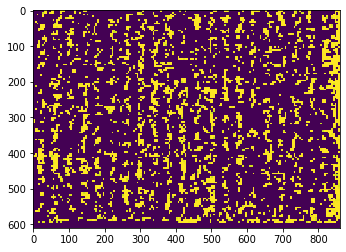

In [40]:
plt.imshow(np_tmp4)

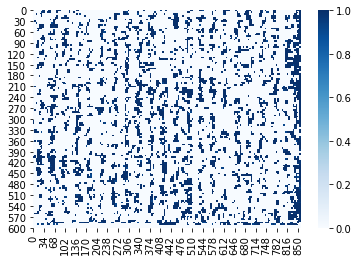

In [41]:
import seaborn as sns
sns.heatmap(np_tmp4, cmap='Blues')

In [42]:
print(np_tmp4.shape)
print(img.shape)

(610, 860)
(609, 860, 3)


In [43]:
np_tmp4

array([[0.        , 0.        , 0.        , ..., 0.99977821, 0.99977821,
        0.99977821],
       [0.        , 0.        , 0.        , ..., 0.99977821, 0.99977821,
        0.99977821],
       [0.        , 0.        , 0.        , ..., 0.99977821, 0.99977821,
        0.99977821],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [44]:
import heatmap
from scipy import ndimage
from skimage import io
import os

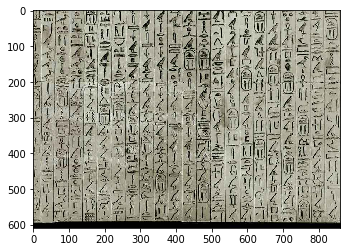

In [45]:
cv2.imwrite(os.path.expanduser('~/sync/Antewest_cropped.png'), img)
image_filename = '~/sync/Antewest_cropped.png'
image = io.imread(image_filename)
plt.imshow(image)

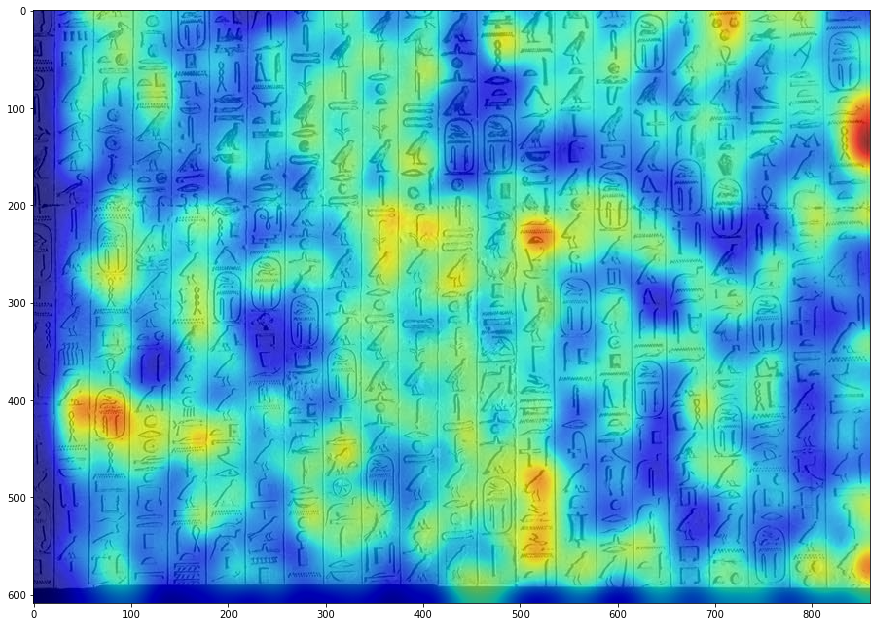

In [50]:
# my_heat_map = ndimage.filters.gaussian_filter(np_tmp4, sigma=16)
np_tmp5 = np.hstack((np.zeros((np_tmp4.shape[0], 25)), np_tmp4[:,:-25]))
my_heat_map = ndimage.filters.gaussian_filter(np_tmp5, sigma=16)
# my_heat_map = ndimage.filters.gaussian_filter(np_tmp4, sigma=16)
plt.figure(figsize=(15,15))
heatmap.add(image, my_heat_map, alpha=0.7,cmap='jet')#, save='../data/face_heat_map.png')
# plt.colorbar()

In [125]:
right_shifted = np_tmp4.copy()

In [135]:
np.hstack((np_tmp4, np.zeros((150, 5))))[:,:350].shape

(150, 350)

In [ ]:
m17 = pred_df[pred_df['predicted'] == 'M17']

In [ ]:
m17.head()

In [ ]:
m17.filename[:5]

In [ ]:
import shutil
for image_file in ['/Users/scott/p5/data/interim/m17/' + name for name in m17.filename.sample(100)]:
    print(image_file)
    shutil.copy2(image_file, '/Users/scott/p5/data/interim/m17/positives')
    


In [ ]:
 # /Users/scott/p5/data/interim/m17

In [ ]:
model = load_model(os.path.expanduser('hieroglyphs_vgg19_M17_only.h5'))

In [ ]:
test_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(os.path.expanduser('/Users/scott/p5/data/interim/m17'), 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)

In [ ]:
# model.predict()
# cv.im

### PLAY

In [ ]:
temp = np.random.randn(50,100)
# temp

In [ ]:
plt.imshow(temp,cmap = 'jet')
plt.colorbar()

In [ ]:
import cv2 


In [ ]:
!ls

In [ ]:
img = cv2.imread('SarcEastGH.jpg')  


In [ ]:
img.shape

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(img)

In [ ]:
temp = np.random.randn(1060,1720,3)


In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(img+temp)